# Users identifications analysis



In [1]:
# Imports
import json
import math
import tldextract
import numpy as np
import statistics
from collections import defaultdict, Counter, OrderedDict
from urllib.parse import urlparse
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, display
import seaborn as sns
import ast 
%matplotlib inline
from itertools import combinations, product
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display, HTML
from scipy.stats import chi2_contingency, fisher_exact
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest


In [2]:
def display_clickable_table(summary_df, key_col, details_dict, other_cols=None):

    # Build table header (use f-string only for the key_col)
    html_content = f"""
    <style>
    .collapsible {{ cursor: pointer; font-weight: bold; padding: 5px; background-color: #e0e0e0; border: none; text-align: left; outline: none; width: 100%; }}
    .content {{ padding: 5px 20px; display: none; overflow: hidden; background-color: #f9f9f9; }}
    table, th, td {{ border: 1px solid black; border-collapse: collapse; padding:5px; }}
    th {{ background-color: #f2f2f2; }}
    </style>

    <table>
    <tr>
    <th>{key_col}</th>
    """

    if other_cols:
        for col in other_cols:
            html_content += f"<th>{col}</th>"
    html_content += "</tr>"

    # Build table rows
    for _, row in summary_df.iterrows():
        key_val = row[key_col]
        details_html = details_dict.get(key_val, "No details available")
        first_col = f"<td><button class='collapsible'>{key_val}</button><div class='content'>{details_html}</div></td>"

        other_cols_html = ""
        if other_cols:
            for col in other_cols:
                other_cols_html += f"<td>{row[col]}</td>"

        html_content += f"<tr>{first_col}{other_cols_html}</tr>"

    html_content += "</table>"

    # Add JavaScript for collapsible rows
    html_content += """
    <script>
    var coll = document.getElementsByClassName("collapsible");
    for (var i = 0; i < coll.length; i++) {
      coll[i].addEventListener("click", function() {
        this.classList.toggle("active");
        var content = this.nextElementSibling;
        if(content){
            content.style.display = (content.style.display === "block") ? "none" : "block";
        }
      });
    }
    </script>
    """

    display(HTML(html_content))


In [3]:
db_params = {
    "host": "localhost",
    "user": "cursor",
    "password": "whaTaShame",
    "db": "crawl_analysis_new",
    "cursorclass": pymysql.cursors.DictCursor
}


In [4]:
def extract_domain(url):
    if not url:
        return None
    try:
        ext = tldextract.extract(url)
        if not ext.domain or not ext.suffix:
            return None
        return f"{ext.domain}.{ext.suffix}".lower()
    except Exception:
        return None

In [5]:
def make_topk_table_hover_wrap(topk_dict, label, wrap_width=50, cell_max_width=400):
    """
    Convert top-k results from topk_attr() into a readable table with HTML line-break wrapping.
    Columns: category-location
    Rows: top-ranked attribute values (up to top 10)
    
    wrap_width: number of characters per line in a cell
    cell_max_width: max width in pixels for a table cell
    """
    data = {}
    max_len = 0

    def wrap_val_html(val):
        """Wrap a long string into multiple lines with <br>."""
        if val is None:
            return "<None>"
        val = str(val)
        return '<br>'.join([val[i:i+wrap_width] for i in range(0, len(val), wrap_width)])

    for (cat, loc), items in topk_dict.items():
        col_name = f"{cat} - {loc}"
        formatted = []
        for val, count, total, frac in items:
            cell_html = f'<div style="max-width:{cell_max_width}px">{wrap_val_html(val)} ({count}/{total}, {frac:.1%})</div>'
            formatted.append(cell_html)

        data[col_name] = formatted
        max_len = max(max_len, len(formatted))

    # pad shorter columns with empty strings
    for col in data:
        if len(data[col]) < max_len:
            data[col] += [""] * (max_len - len(data[col]))

    df_out = pd.DataFrame(data)
#    df_out.index = [f"Top {i+1}" for i in range(max_len)]

    # display as HTML
#    display(HTML(f"<h3>{label}</h3>"))
    display(HTML(df_out.to_html(escape=False)))  # escape=False to render HTML
    return df_out

In [7]:
def load_rows(conn_params):
    sql = """
    SELECT id, etld, url, category, location, user_identifiers, is_user_identifiers
    FROM crawl_sessions
    WHERE category NOT LIKE '%validation' AND location not like '%VPN' AND is_user_identifiers IS NOT NULL and etld_url_rel <> 'cross-site'

    """
    
    conn = pymysql.connect(
        host=conn_params['host'],
        user=conn_params['user'],
        password=conn_params['password'],
        db=conn_params['db'],
        cursorclass=pymysql.cursors.DictCursor
    )
    
    try:
        with conn.cursor() as cursor:
            cursor.execute(sql)
            rows = cursor.fetchall()  # list of dicts
            df = pd.DataFrame(rows)
    finally:
        conn.close()
    
    return df

# Load data
print('Loading rows from DB...')
df = load_rows(db_params)
print(f'Loaded {len(df)} rows')

# Normalize some columns
df['etld'] = df['etld'].astype(str).str.lower()
df['category'] = df['category'].astype(str)
df['location'] = df['location'].astype(str)



Loading rows from DB...
Loaded 0 rows


KeyError: 'etld'

In [7]:
#Expand the user-identification columns (one column per type)

def safe_parse(val):
    if pd.isna(val):
        return {}
    if isinstance(val, dict):
        return val
    if isinstance(val, str):
        val = val.strip()
        if val == "" or val.lower() in ["none", "nan"]:
            return {}
        try:
            return json.loads(val)  # JSON-style with double quotes
        except json.JSONDecodeError:
            try:
                return ast.literal_eval(val)  # Python-style with single quotes
            except Exception:
                return {}
    return {}


df["user_identifiers"] = df["user_identifiers"].apply(safe_parse)


user_identifiers = df["user_identifiers"].apply(pd.Series)


for col in user_identifiers.columns:
    df[f"is_{col}"] = user_identifiers[col].apply(lambda x: bool(x))
    df[f"{col}"] = user_identifiers[col]

df


id                        etld  \
0            1        www.astroworld.co.in   
1            2        www.astroworld.co.in   
2            3        www.astroworld.co.in   
3            4        www.astroworld.co.in   
4            5        www.astroworld.co.in   
...        ...                         ...   
180617  319216  www.preinscriptions.ufc.dz   
180618  319217  www.preinscriptions.ufc.dz   
180619  319218  www.preinscriptions.ufc.dz   
180620  319219  www.preinscriptions.ufc.dz   
180621  319220  www.preinscriptions.ufc.dz   

                                                      url          category  \
0                           https://www.astroworld.co.in/     country_coded   
1        https://www.astroworld.co.in/category/horoscope/     country_coded   
2       https://www.astroworld.co.in/category/horoscop...     country_coded   
3               https://www.astroworld.co.in/bhadra-yoga/     country_coded   
4              https://www.astroworld.co.in/agni-rigveda/     country_coded   
...                                                   ...               ...   
180617          http://www.preinscriptions.ufc.dz//step2/  country_specific   
180618           http://www.preinscriptions.ufc.dz/step2/  country_specific   
180619  http://www.preinscriptions.ufc.dz//uploads/doc...  country_specific   
180620                 http://www.preinscriptions.ufc.dz/  country_specific   
180621  http://www.preinscriptions.ufc.dz//uploads/doc...  country_specific   

       location                                   user_identifiers  \
0         INDIA  {'local_storage_identifiers': [], 'cookies_sto...   
1         INDIA  {'local_storage_identifiers': [], 'cookies_sto...   
2         INDIA  {'local_storage_identifiers': [], 'cookies_sto...   
3         INDIA  {'local_storage_identifiers': [], 'cookies_sto...   
4         INDIA  {'local_storage_identifiers': [], 'cookies_sto...   
...         ...                                                ...   
180617  ALGERIA  {'local_storage_identifiers': [], 'cookies_sto...   
180618  ALGERIA  {'local_storage_identifiers': [], 'cookies_sto...   
180619  ALGERIA  {'local_storage_identifiers': [], 'cookies_sto...   
180620  ALGERIA  {'local_storage_identifiers': [], 'cookies_sto...   
180621  ALGERIA  {'local_storage_identifiers': [], 'cookies_sto...   

        is_user_identifiers  is_local_storage_identifiers  \
0                         0                         False   
1                         0                         False   
2                         0                         False   
3                         0                         False   
4                         0                         False   
...                     ...                           ...   
180617                    0                         False   
180618                    0                         False   
180619                    0                         False   
180620                    0                         False   
180621                    0                         False   

       local_storage_identifiers  is_cookies_storage_identifiers  \
0                             []                           False   
1                             []                           False   
2                             []                           False   
3                             []                           False   
4                             []                           False   
...                          ...                             ...   
180617                        []                           False   
180618                        []                           False   
180619                        []                           False   
180620                        []                           False   
180621                        []                           False   

       cookies_storage_identifiers  is_session_storage_identifiers  \
0                               []               

## Distinct ETLDs and URL counts

In [8]:
# Group selected rows by (category, location) and count distinct ETLDs
group = df.groupby(['category','location'])

distinct_etlds = group['etld'].nunique().reset_index().rename(columns={'etld':'distinct_etlds'})
distinct_etlds


category location  distinct_etlds
0     country_coded  ALGERIA             209
1     country_coded  GERMANY            6651
2     country_coded    INDIA            6047
3     country_coded      UAE            1165
4  country_specific  ALGERIA            2453
5  country_specific  GERMANY            8829
6  country_specific    INDIA            8773
7  country_specific      UAE            8930

In [9]:
# For each etld compute number of distinct urls, then compute avg/median/std per (category, location)
etld_url_counts = df.groupby(['category','location','etld'])['url'].nunique().reset_index().rename(columns={'url':'n_unique_urls'})

agg_stats = etld_url_counts.groupby(['category','location'])['n_unique_urls'].agg(['mean','median','std','count']).reset_index()
agg_stats = agg_stats.rename(columns={'mean':'avg_urls_per_etld','median':'median_urls_per_etld','std':'std_urls_per_etld'})
agg_stats


category location  avg_urls_per_etld  median_urls_per_etld  \
0     country_coded  ALGERIA           4.349282                   5.0   
1     country_coded  GERMANY           4.738235                   5.0   
2     country_coded    INDIA           4.362990                   5.0   
3     country_coded      UAE           4.694421                   5.0   
4  country_specific  ALGERIA           3.797391                   5.0   
5  country_specific  GERMANY           4.358818                   5.0   
6  country_specific    INDIA           3.629089                   5.0   
7  country_specific      UAE           4.110862                   5.0   

   std_urls_per_etld  count  
0           1.392808    209  
1           2.685222   6651  
2           1.612382   6047  
3           1.930763   1165  
4           1.746624   2453  
5           2.193083   8829  
6           1.846820   8773  
7           1.568400   8930

### Reading actions on the Cookies/localStorage/sessionStorage jars

#### For cookies: We focus only on cookie-set events
#### For localStorage and sessionStorage: We consider localStorage.get and sessionStorage.get (we do not have localStorage.set and sessionStorage.set events) 

In [10]:
identification_types = [c for c in df.columns if c.endswith('_identifiers') and not c.startswith('is') and c!= 'user_identifiers' ]

records = []

for idx, row in df.iterrows():
    for identification_col in identification_types:
        identification_type = identification_col.replace('_identifiers', '') 
        id_list = row[identification_col]
        if id_list: 
            for id_case in id_list:
                record = {
                    'category': row['category'],
                    'location': row['location'],
                    'etld': row['etld'],
                    'url': row['url'],
                    'identification_type': identification_type
                }
                record.update(id_case)
                records.append(record)

id_df = pd.DataFrame(records)


mask = (id_df['identification_type'] != 'cookies_storage') | \
       ((id_df['identification_type'] == 'cookies_storage') & (id_df['event_type'] == 'storage set'))

id_df = id_df[mask]

cols_to_exclude = ['caller_id','caller_hash'] 
id_df = id_df.drop(columns=[c for c in cols_to_exclude if c in id_df.columns])


#### Ignoring duplicates: We ignore cases where the same script (caller_url), sets the same key/value pair, in the same storage jar, more than once 

In [11]:

def drop_duplicates(df):

    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # 1. Identify columns that contain lists
    list_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]

    # 2. Convert lists to strings temporarily
    for col in list_cols:
        df.loc[:, col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else x)

    # 3. Drop duplicates
    df = df.drop_duplicates(ignore_index=True)

    # 4. Convert stringified lists back to lists
    def safe_eval(x):
        if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
            try:
                return ast.literal_eval(x)
            except Exception:
                # Handle escaped quotes and malformed JSON-like strings
                cleaned = x.replace('\\"', '"').replace("\\'", "'")
                try:
                    return ast.literal_eval(cleaned)
                except Exception:
                    return x
        return x

    for col in list_cols:
        df.loc[:, col] = df[col].map(safe_eval)

    return df

id_df = drop_duplicates(id_df)

id_df

category location                   etld  \
0           country_coded    INDIA       www.image.edu.in   
1           country_coded    INDIA       www.image.edu.in   
2           country_coded    INDIA       www.image.edu.in   
3           country_coded    INDIA       www.image.edu.in   
4           country_coded    INDIA       www.image.edu.in   
...                   ...      ...                    ...   
1097345  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097346  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097347  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097348  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097349  country_specific  ALGERIA  omexpress.ecotrack.dz   

                                                       url  \
0        https://www.image.edu.in/image-opens-new-centr...   
1        https://www.image.edu.in/image-opens-new-centr...   
2        https://www.image.edu.in/image-opens-new-centr...   
3        https://www.image.edu.in/image-opens-new-centr...   
4        https://www.image.edu.in/image-opens-new-centr...   
...                                                    ...   
1097345         https://omexpress.ecotrack.dz/driver/login   
1097346         https://omexpress.ecotrack.dz/driver/login   
1097347                https://omexpress.ecotrack.dz/login   
1097348                https://omexpress.ecotrack.dz/login   
1097349                https://omexpress.ecotrack.dz/login   

        identification_type                  key  \
0             local_storage             li adsId   
1             local_storage             li adsId   
2             local_storage             li adsId   
3             local_storage             li adsId   
4             local_storage             li adsId   
...                     ...                  ...   
1097345       local_storage  rc::d-1760073154751   
1097346     session_storage                rc::c   
1097347       local_storage                rc::f   
1097348       local_storage  rc::d-1760073189867   
1097349     session_storage                rc::c   

                                                       val  \
0                     d9a674f8-79a0-4b8f-8978-46df148df63d   
1                     d9a674f8-79a0-4b8f-8978-46df148df63d   
2                     d9a674f8-79a0-4b8f-8978-46df148df63d   
3                     d9a674f8-79a0-4b8f-8978-46df148df63d   
4                     d9a674f8-79a0-4b8f-8978-46df148df63d   
...                                                    ...   
1097345                                   dmtkaGxmY2dvZnp4   
1097346  BEIlFUUapjmhL_NPdLLU7TntY2Hl9VUKZZvtsqBaNOVhIr...   
1097347  0aAGmBFisbh1IkUFkZkLWgyGxA8AIUmKt_kHqFCWZ5SNzC...   
1097348                                   cjZtYzg1aWg2eHE3   
1097349  BEIlFUUapjmhL_NPdLLUzUFFX0Hl9WnieZvtsqBaPRlhio...   

                                                caller_url    caller_type  \
0        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
1                 https://www.image.edu.in/js/modernizr.js  external file   
2        https://snap.licdn.com/li.lms-analytics/insigh...  external file   
3        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
4        https://www.googletagmanager.com/gtm.js?id=GTM...  external file   
...                                                    ...            ...   
1097345  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097346  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097347  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097348  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097349  https://www.gstatic.com/recaptcha/releases/bGi...  external file   

        event_type script_type  
0              NaN         NaN  
1              NaN         NaN  
2              NaN         NaN  
3              NaN         NaN  
4              NaN         NaN  
...            ...         ...  
1097345      

In [12]:
print('Number of UIDs in cookies:', id_df[id_df['identification_type'] == 'cookies_storage'].shape[0])

print('Number of UIDs in local_storage:', id_df[id_df['identification_type'] == 'local_storage'].shape[0])

print('Number of UIDs in session_storage:', id_df[id_df['identification_type'] == 'session_storage'].shape[0])


Number of UIDs in cookies: 75507
Number of UIDs in local_storage: 950902
Number of UIDs in session_storage: 70941


## 1) How prevalent is user identification in each country / bucket?

In [13]:
# per etld, per (category,location) whether any row has is_fp_bool True
etld_id = df.groupby(['category','location','etld'])['is_user_identifiers'].any().reset_index()

# fraction per (category,location)
etld_counts = etld_id.groupby(['category','location'])['etld'].nunique().reset_index().rename(columns={'etld':'total_etlds'})
etld_with_id = etld_id[etld_id['is_user_identifiers']].groupby(['category','location'])['etld'].nunique().reset_index().rename(columns={'etld':'etlds_with_id'})

id_fraction = pd.merge(etld_counts, etld_with_id, on=['category','location'], how='left').fillna(0)
id_fraction['fraction_with_id'] = id_fraction['etlds_with_id'] / id_fraction['total_etlds']

# pivot to table: rows=category, cols=location
id_pivot = id_fraction.pivot(index='category', columns='location', values='fraction_with_id')

id_pivot.fillna(0).round(4)
id_pivot_percent = (id_pivot * 100).round(2)
print('Percentage of websites where at least one UID was created:')

print()

id_pivot_percent


Percentage of websites where at least one UID was created:



location          ALGERIA  GERMANY  INDIA    UAE
category                                        
country_coded       32.54    54.74  39.44  60.69
country_specific    26.25    49.25  27.00  45.55

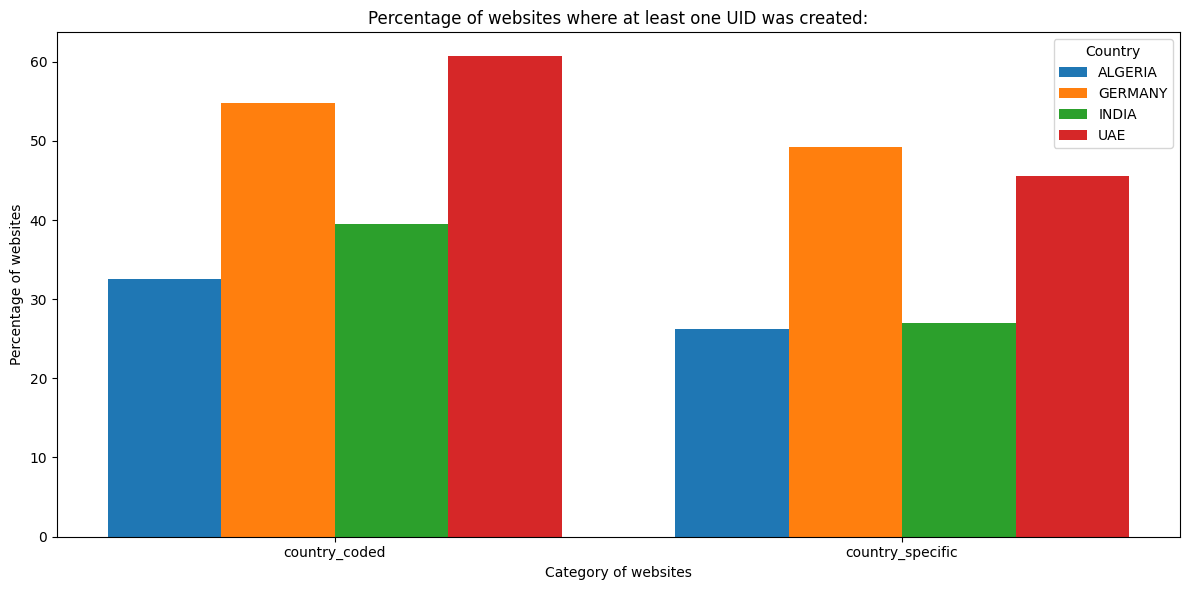

In [14]:
categories = id_pivot_percent.index
locations = id_pivot_percent.columns
x = np.arange(len(categories))  # the label locations
width = 0.8 / len(locations)    # bar width

fig, ax = plt.subplots(figsize=(12, 6))

for i, loc in enumerate(locations):
    ax.bar(x + i*width, id_pivot_percent[loc], width, label=loc)

ax.set_xticks(x + width*(len(locations)-1)/2)
ax.set_xticklabels(categories)
ax.set_ylabel('Percentage of websites')
ax.set_xlabel('Category of websites')
ax.set_title('Percentage of websites where at least one UID was created:')
ax.legend(title='Country')
plt.tight_layout()
plt.show()

#### Statistical test - Does the category / category affect the fraction of websites where at least 1 UID was created

In [15]:
uid_counts = df[df['is_user_identifiers'] == True] \
              .groupby(['category', 'location'])['etld'].nunique() \
              .unstack(fill_value=0)


total_counts = df.groupby(['category', 'location'])['etld'].nunique().unstack(fill_value=0)

non_uid_counts = total_counts - uid_counts

uid_by_category = uid_counts.sum(axis=1)
non_uid_by_category = non_uid_counts.sum(axis=1)
chi_table_category = pd.concat([uid_by_category, non_uid_by_category], axis=1)
chi_table_category.columns = ['is_uid', 'not_uid']

print('Contingency table for cateogry:')
print()
print(chi_table_category)
print()
    
chi2_cat, p_cat, dof_cat, _ = chi2_contingency(chi_table_category)
print("Chi-square test for effect of category:")
print(f"Chi2 = {chi2_cat:.2f}, p-value = {p_cat:.2e}")

print()
print('------------------------------------------------------------------------------------')
print()



# --- Test 2: Effect of location only ---
uid_by_location = uid_counts.sum(axis=0)
non_uid_by_location = non_uid_counts.sum(axis=0)
chi_table_location = pd.concat([uid_by_location, non_uid_by_location], axis=1)
chi_table_location.columns = ['is_uid', 'not_uid']


print('Contingency table for country:')
print()
print(chi_table_location)
print()


chi2_loc, p_loc, dof_loc, _ = chi2_contingency(chi_table_location)
print("Chi-square test for effect of country:")
print(f"Chi2 = {chi2_loc:.2f}, p-value = {p_loc:.2e}")


print()
print('------------------------------------------------------------------------------------')
print()


print('Contingency table for country/category:')
print()
print(uid_counts)
print()


# --- Test 3: Effect of category + location (interaction) ---
chi2_full, p_full, dof_full, _ = chi2_contingency(uid_counts)
print("Chi-square test for effect of country/category (combination):")
print(f"Chi2 = {chi2_full:.2f}, p-value = {p_full:.2e}")


Contingency table for cateogry:

                  is_uid  not_uid
category                         
country_coded       6801     7271
country_specific   11429    17556

Chi-square test for effect of category:
Chi2 = 306.94, p-value = 1.01e-68

------------------------------------------------------------------------------------

Contingency table for country:

          is_uid  not_uid
location                 
ALGERIA      712     1950
GERMANY     7989     7491
INDIA       4754    10066
UAE         4775     5320

Chi-square test for effect of country:
Chi2 = 1550.84, p-value = 0.00e+00

------------------------------------------------------------------------------------

Contingency table for country/category:

location          ALGERIA  GERMANY  INDIA   UAE
category                                       
country_coded          68     3641   2385   707
country_specific      644     4348   2369  4068

Chi-square test for effect of country/category (combination):
Chi2 = 1837.87, p-value

**Interpretation:** 

- UID creation is **most prevalent in UAE and Germany**, across both website categories.  
- **Country-coded sites** show slightly higher UID rates than **country-specific** ones, suggesting stronger identifier practices in more globally oriented domains.


**Statistical testing:** Category, Location, and Category/Location have a significant effect on UID behavior 



----
## 2) How prevalent are UIDs across countries and site buckets, for cookies, local_storage, and session_storage separately?

In [16]:
all_types = id_df['identification_type'].unique()

for t in all_types:
    id_df[f'is_{t}'] = id_df['identification_type'].eq(t)

id_flags = id_df.groupby(['category','location','etld'])[ [f'is_{t}' for t in all_types] ].any().reset_index()

total_etlds_per_group = df.groupby(['category','location'])['etld'].nunique().reset_index().rename(columns={'etld':'total_etlds'})

type_cols = [f'is_{t}' for t in all_types]
type_counts = id_flags.groupby(['category','location'])[type_cols].sum().reset_index()

type_percent_df = pd.merge(type_counts, total_etlds_per_group, on=['category','location'])

for col in type_cols:
    type_percent_df[col] = (type_percent_df[col] / type_percent_df['total_etlds'] * 100).round(2)

id_flags['any_UID'] = id_flags[type_cols].any(axis=1)
any_id_fraction = id_flags.groupby(['category','location'])['any_UID'].sum().reset_index()
any_id_fraction = pd.merge(any_id_fraction, total_etlds_per_group, on=['category','location'])
any_id_fraction['All_UIDs'] = (any_id_fraction['any_UID'] / any_id_fraction['total_etlds'] * 100).round(2)

final_cleaned_df = pd.merge(
    type_percent_df,
    any_id_fraction[['category','location','All_UIDs']],
    on=['category','location'],
    how='left'
)

cols = final_cleaned_df.columns.tolist()

new_order = ['category', 'location', 'total_etlds', 'All_UIDs'] + [c for c in cols if c not in ['category', 'location', 'total_etlds', 'All_UIDs']]

final_cleaned_df = final_cleaned_df[new_order]

print('Percentage of websites where UID was observed in each Bucket/Location:')
print()

final_cleaned_df

Percentage of websites where UID was observed in each Bucket/Location:



category location  total_etlds  All_UIDs  is_local_storage  \
0     country_coded  ALGERIA          209     26.79             19.62   
1     country_coded  GERMANY         6651     44.94             31.09   
2     country_coded    INDIA         6047     32.12             22.61   
3     country_coded      UAE         1165     53.99             42.58   
4  country_specific  ALGERIA         2453     18.92             12.19   
5  country_specific  GERMANY         8829     37.98             28.04   
6  country_specific    INDIA         8773     21.11             15.01   
7  country_specific      UAE         8930     37.77             25.49   

   is_session_storage  is_cookies_storage  
0                8.61               11.00  
1               18.75               30.21  
2               13.94               18.41  
3               23.43               36.91  
4                6.24                6.81  
5               13.24               25.22  
6                5.17               13.86  
7               14.93               22.83

In [17]:
id_type_cols = [c for c in final_cleaned_df.columns if c.startswith('is_')]

heatmap_data = final_cleaned_df.melt(
    id_vars=['category','location'],
    value_vars=id_type_cols,
    var_name='UID Type',
    value_name='Percentage'
)

heatmap_data['UID Type'] = heatmap_data['UID Type'].str.replace('is_', '')
heatmap_data['Category - Location'] = heatmap_data['category'] + ' - ' + heatmap_data['location']

plt.figure(figsize=(12,8))
pivot_table = heatmap_data.pivot_table(
    index='Category - Location',
    columns='UID Type',
    values='Percentage'
)

sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Percentage of ETLDs'})
plt.title('Percentage of websites on which at least one UID was created per Bucket/location')
plt.ylabel('Location')
plt.xlabel('UID Type')
plt.tight_layout()
plt.show()



**Interpretation:**  
- **Cookies** remain one of the most common methods of storing user identifiers, especially in **Germany** and **UAE**.  
- **Local storage** usage is also prominent, suggesting that many sites rely on persistent browser storage beyond cookies.  
- **Session storage** is used less frequently overall, indicating a preference for more persistent tracking mechanisms.  

#### Statistical test - Does the distribution of user identification per storage jar differ by location?

In [18]:
type_by_loc = id_flags.groupby("location")[type_cols].sum().T


chi2, p, dof, expected = chi2_contingency(type_by_loc)

print('Contengency table:')
print()

print(type_by_loc)

print()
print(f"Chi-squared test p-value: {p:.4f}")

Contengency table:

location            ALGERIA  GERMANY  INDIA   UAE
is_local_storage        340     4544   2684  2772
is_session_storage      171     2416   1297  1606
is_cookies_storage      190     4236   2329  2469

Chi-squared test p-value: 0.0000


#### **Interpretation:**  

- **Local storage** is the most prominent.
- **Cookies** second most common  
- **Session storage** is used less frequently overall. 
    

------

### **Alternative view**



In [19]:
etld_counts = (
    df
    .groupby(['category', 'location'])['etld']
    .nunique()
    .reset_index(name='num_etlds')
)

uid_counts = (
    id_df
    .groupby(['category', 'location'])
    .size()
    .reset_index(name='num_uid_cases')
)

stats_df = pd.merge(etld_counts, uid_counts, on=['category', 'location'], how='left')
stats_df['num_uid_cases'] = stats_df['num_uid_cases'].fillna(0).astype(int)

stats_df = stats_df.sort_values(['category', 'location']).reset_index(drop=True)

print('Total number of UID instances in each Bucket/Country: ')
print()
stats_df


Total number of UID instances in each Bucket/Country: 



category location  num_etlds  num_uid_cases
0     country_coded  ALGERIA        209           1229
1     country_coded  GERMANY       6651         267663
2     country_coded    INDIA       6047         117067
3     country_coded      UAE       1165          77585
4  country_specific  ALGERIA       2453          26771
5  country_specific  GERMANY       8829         331044
6  country_specific    INDIA       8773         155192
7  country_specific      UAE       8930         120799

**a. Germany dominates overall UID activity**
- Germany leads across both categories, with **~600K UID instances total** — nearly double that of any other country.  
- This aligns with earlier findings where Germany also had **high UID prevalence**, but it now shows **much higher UID volume**, suggesting **denser tracking per site**.

**b. UAE shows fewer sites but high UID density**
- Although the UAE has **fewer websites** (especially in the *country_coded* group), it still reports **77K–120K UID cases**.  
- This suggests that **UAE sites are more UID-heavy per domain**, matching the earlier observation that the **fraction of sites with UIDs was highest** in UAE.


--- 

## 3) How are scripts loaded and executed (caller types) across different countries and site types?

### Possible Script Load / Execution Types



#### **a. Inline**
- JS code written directly inside the HTML page using a `<script>` tag without a `src`.  
- Runs in the page's origin context


#### **b. Inline inside generated element (dynamically injected script)**

- Script nodes created and inserted into the DOM at runtime by other JavaScript.
- Can be first-party or third-party.  
- Executes in the page's origin.  
- **Example:**
```
    var script = document.createElement('script');
    script.textContent = "console.log('dynamic inline code')";
    document.body.appendChild(script);

    var s2 = document.createElement('script');
    s2.src = 'https://cdn.example.com/dynamic.js';
    document.head.appendChild(s2);
```



#### **c. External file**
- Scripts loaded from a separate `.js` file via `<script src="...">`.  
- May be same-origin or cross-origin. Both execute in page origin.  
- **Example:**
```
    <script src="https://example.com/fingerprint.js"></script>
```


#### **d. Module**
- Scripts with `type="module"`. 
- Can be same-origin or cross-origin.
- **Example:**
```
    <script type="module" src="app.js"></script>
```


#### **e. Eval**
- Code executed dynamically from a string at runtime using `eval()`.  
- **Origin / cross-site:** Runs in page's origin context.



In [20]:
caller_type_counts = id_df.groupby(['category','location','caller_type']).size().reset_index(name='count')

caller_type_dist = caller_type_counts.pivot_table(
    index=['category','location'],
    columns='caller_type',
    values='count',
    fill_value=0
).reset_index()

total_cases_per_group = id_df.groupby(['category','location']).size().reset_index(name='total_cases')

caller_type_dist = pd.merge(caller_type_dist, total_cases_per_group, on=['category','location'])

for col in caller_type_dist.columns:
    if col not in ['category','location','total_cases']:
        caller_type_dist[col] = (caller_type_dist[col] / caller_type_dist['total_cases'] * 100).round(2)


cols = caller_type_dist.columns.tolist()

new_order = ['category', 'location', 'total_cases'] + [c for c in cols if c not in ['category','location','total_cases']]

caller_type_dist = caller_type_dist[new_order]

print("Percentage of UIDs that set by inline scripts, external files, eval, ...etc per bucket/location:")
print()

caller_type_dist

Percentage of UIDs that set by inline scripts, external files, eval, ...etc per bucket/location:



category location  total_cases  eval  eval for scheduled action  \
0     country_coded  ALGERIA         1229  2.69                        0.0   
1     country_coded  GERMANY       267663  2.09                        0.0   
2     country_coded    INDIA       117067  3.72                        0.0   
3     country_coded      UAE        77585  1.52                        0.0   
4  country_specific  ALGERIA        26771  0.00                        0.0   
5  country_specific  GERMANY       331044  1.53                        0.0   
6  country_specific    INDIA       155192  0.90                        0.0   
7  country_specific      UAE       120799  0.66                        0.0   

   external file  inline  inline inside document write  \
0          78.11    0.65                          0.00   
1          86.32    2.19                          0.02   
2          80.05    1.84                          0.04   
3          87.55    2.09                          0.00   
4          95.97    0.10                          0.00   
5          87.79    3.36                          0.00   
6          86.24    2.91                          0.00   
7          83.20    1.80                          0.00   

   inline inside generated element  module  script  
0                             0.41    5.21   12.94  
1                             0.91    1.87    6.52  
2                             3.11    2.80    8.44  
3                             0.74    1.50    6.60  
4                             0.00    0.09    3.84  
5                             0.76    1.90    4.60  
6                             0.43    1.51    8.00  
7                             0.65    1.91   11.77

In [21]:
heatmap_data = caller_type_dist.melt(
    id_vars=['category','location'],
    value_vars=[c for c in caller_type_dist.columns if c not in ['category','location','total_cases']],
    var_name='caller_type',
    value_name='Percentage'
)

# Create a combined category-location string for y-axis
heatmap_data['cat_loc'] = heatmap_data['category'] + " - " + heatmap_data['location']

# Pivot for heatmap
pivot_table = heatmap_data.pivot(index='cat_loc', columns='caller_type', values='Percentage')

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Percentage of user identification cases'})
plt.title('Caller Type Distribution per Category-Location')
plt.ylabel('Category - Location')
plt.xlabel('Caller Type')
plt.tight_layout()
plt.show()

#### Most UIDs are set by **external scripts**.  

#### Statistical test -- the effect of bucket / country on the load type

In [22]:

# Columns representing the caller types
caller_type_cols = ['eval','external file','inline','inline inside generated element','module','unknown']

# -------------------------
# 1. Effect of Location
# -------------------------
# What we are testing:
# Are the distributions of caller types different across locations, ignoring the category of the call?
location_table = id_df.groupby(['location','caller_type']).size().unstack(fill_value=0)

# How we are testing:
# Chi-square test of independence compares the observed counts (location_table)
# with the counts we would expect if caller types were independent of location.

chi2_loc, p_loc, dof_loc, expected_loc = chi2_contingency(location_table)

# Why it works:
# The chi-square statistic sums ((observed - expected)^2 / expected) across all cells.
# Large differences between observed and expected counts give a high chi2 value, suggesting dependence.

print("=== Effect of Location ===")
print("Testing whether caller type distribution differs by location (ignoring category).\n")
print('Contengency table:')
print()
print(location_table)
print()
print(f"Chi-square statistic = {chi2_loc:.2f}, Degrees of freedom = {dof_loc}, p-value = {p_loc:.4e}\n")

if p_loc < 0.05:
    print("Result: Significant difference in caller type distribution across locations (reject H0).")
else:
    print("Result: No significant difference in caller type distribution across locations (fail to reject H0).")
print("\n")

# -------------------------
# 2. Effect of Category
# -------------------------
# What we are testing:
# Are the distributions of caller types different across categories, ignoring location?
category_table = id_df.groupby(['category','caller_type']).size().unstack(fill_value=0)

chi2_cat, p_cat, dof_cat, expected_cat = chi2_contingency(category_table)

print("=== Effect of Category ===")
print("Testing whether caller type distribution differs by category (ignoring location).\n")
print('Contengency table:')
print()
print(location_table)
print()
print(f"Chi-square statistic = {chi2_cat:.2f}, Degrees of freedom = {dof_cat}, p-value = {p_cat:.4e}\n")

if p_cat < 0.05:
    print("Result: Significant difference in caller type distribution across categories (reject H0).")
else:
    print("Result: No significant difference in caller type distribution across categories (fail to reject H0).")
print("\n")

# -------------------------
# 3. Effect of Location × Category (Interaction)
# -------------------------
# What we are testing:
# Do caller type distributions differ when considering both location and category together?
interaction_table = id_df.groupby(['category','location','caller_type']).size().unstack(fill_value=0)

# Flatten the multiindex so that each row is a unique category-location combination
chi2_inter, p_inter, dof_inter, expected_inter = chi2_contingency(interaction_table)

print("=== Effect of Location × Category Interaction ===")
print("Testing whether caller type distribution differs when considering both location and category together.\n")
print('Contengency table:')
print()
print(location_table)
print()
print(f"Chi-square statistic = {chi2_inter:.2f}, Degrees of freedom = {dof_inter}, p-value = {p_inter:.4e}\n")

if p_inter < 0.05:
    print("Result: Significant interaction effect (caller type distribution depends on both location and category).")
else:
    print("Result: No significant interaction effect (distribution does not depend on the combination).")


=== Effect of Location ===
Testing whether caller type distribution differs by location (ignoring category).

Contengency table:

caller_type   eval  eval for scheduled action  external file  inline  \
location                                                               
ALGERIA         33                          0          26652      35   
GERMANY      10645                          1         521659   16989   
INDIA         5758                          0         227551    6672   
UAE           1977                          0         168430    3788   

caller_type  inline inside document write  inline inside generated element  \
location                                                                     
ALGERIA                                 0                                5   
GERMANY                                62                             4934   
INDIA                                  46                             4311   
UAE                                     0      

----
# 4) What scripts create UIDs 

## 4.1. First-party / third-party?

In [23]:
import tldextract
from urllib.parse import urlparse

def get_relation(current_domain, current_subdomain, caller_domain, caller_subdomain):
    current_domain = current_domain.lower()
    current_subdomain = current_subdomain.lower() if current_subdomain else ''
    caller_domain = caller_domain.lower()
    caller_subdomain = caller_subdomain.lower() if caller_subdomain else ''

    if pd.isna(caller_domain) or caller_domain == '':
        return 'First-party'
    
    if caller_domain == current_domain:
        if caller_subdomain == current_subdomain:
            return 'First-party'  # same origin
        else:
            return 'First-party'  # cross origin on same domain
    else:
        return 'Third-party'


def extract_url_info(url):
    if pd.isna(url) or url.strip() == '':
        return '', '', ''
    ext = tldextract.extract(url)
    domain = ext.top_domain_under_public_suffix
    subdomain = ext.subdomain
    # origin = scheme + "://" + netloc
    parsed = urlparse(url)
    origin = parsed.netloc if parsed.netloc else ''
    return domain, origin, subdomain


id_df[['current_domain','current_origin','current_subdomain']] = id_df['url'].apply(
    lambda x: pd.Series(extract_url_info(x))
)

id_df[['caller_domain','caller_origin','caller_subdomain']] = id_df['caller_url'].apply(
    lambda x: pd.Series(extract_url_info(x))
)


id_df['call_context'] = id_df.apply(
    lambda row: get_relation(row['current_domain'], row['current_subdomain'],
                             row['caller_domain'], row['caller_subdomain']),
    axis=1
)


print('Assigning First-party / Third-party label to each UID (caller_url v.s. current_url):')

print()

id_df

Assigning First-party / Third-party label to each UID (caller_url v.s. current_url):



category location                   etld  \
0           country_coded    INDIA       www.image.edu.in   
1           country_coded    INDIA       www.image.edu.in   
2           country_coded    INDIA       www.image.edu.in   
3           country_coded    INDIA       www.image.edu.in   
4           country_coded    INDIA       www.image.edu.in   
...                   ...      ...                    ...   
1097345  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097346  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097347  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097348  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097349  country_specific  ALGERIA  omexpress.ecotrack.dz   

                                                       url  \
0        https://www.image.edu.in/image-opens-new-centr...   
1        https://www.image.edu.in/image-opens-new-centr...   
2        https://www.image.edu.in/image-opens-new-centr...   
3        https://www.image.edu.in/image-opens-new-centr...   
4        https://www.image.edu.in/image-opens-new-centr...   
...                                                    ...   
1097345         https://omexpress.ecotrack.dz/driver/login   
1097346         https://omexpress.ecotrack.dz/driver/login   
1097347                https://omexpress.ecotrack.dz/login   
1097348                https://omexpress.ecotrack.dz/login   
1097349                https://omexpress.ecotrack.dz/login   

        identification_type                  key  \
0             local_storage             li adsId   
1             local_storage             li adsId   
2             local_storage             li adsId   
3             local_storage             li adsId   
4             local_storage             li adsId   
...                     ...                  ...   
1097345       local_storage  rc::d-1760073154751   
1097346     session_storage                rc::c   
1097347       local_storage                rc::f   
1097348       local_storage  rc::d-1760073189867   
1097349     session_storage                rc::c   

                                                       val  \
0                     d9a674f8-79a0-4b8f-8978-46df148df63d   
1                     d9a674f8-79a0-4b8f-8978-46df148df63d   
2                     d9a674f8-79a0-4b8f-8978-46df148df63d   
3                     d9a674f8-79a0-4b8f-8978-46df148df63d   
4                     d9a674f8-79a0-4b8f-8978-46df148df63d   
...                                                    ...   
1097345                                   dmtkaGxmY2dvZnp4   
1097346  BEIlFUUapjmhL_NPdLLU7TntY2Hl9VUKZZvtsqBaNOVhIr...   
1097347  0aAGmBFisbh1IkUFkZkLWgyGxA8AIUmKt_kHqFCWZ5SNzC...   
1097348                                   cjZtYzg1aWg2eHE3   
1097349  BEIlFUUapjmhL_NPdLLUzUFFX0Hl9WnieZvtsqBaPRlhio...   

                                                caller_url    caller_type  \
0        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
1                 https://www.image.edu.in/js/modernizr.js  external file   
2        https://snap.licdn.com/li.lms-analytics/insigh...  external file   
3        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
4        https://www.googletagmanager.com/gtm.js?id=GTM...  external file   
...                                                    ...            ...   
1097345  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097346  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097347  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097348  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097349  https://www.gstatic.com/recaptcha/releases/bGi...  external file   

        event_type  ... is_local_storage  is_session_storage  \
0              NaN  ...             True               False   
1              NaN  ...             True               False   
2              NaN  ...             True            

In [25]:
storage_cols = ['is_cookies_storage', 'is_local_storage', 'is_session_storage']

for storage in storage_cols:
    storage_df = id_df[id_df[storage]]

    # Crosstab call_context per category/location
    call_context_counts = pd.crosstab(
        index=[storage_df['category'], storage_df['location']],
        columns=storage_df['call_context']
    )
    
    # Convert counts to percentages per row (category/location)
    call_context_percent = call_context_counts.div(call_context_counts.sum(axis=1), axis=0) * 100
    call_context_percent = call_context_percent.round(2)
    
    # Reset index for display
    call_context_percent_df = call_context_percent.reset_index()
    
    print(f'Distribution of First-party/Third-party UIDs for {storage} per Bucket-Location:\n')
    print(call_context_percent_df)
    print('\n' + '-'*80 + '\n')


Distribution of First-party/Third-party UIDs for is_cookies_storage per Bucket-Location:

call_context          category location  First-party  Third-party
0                country_coded  ALGERIA        11.32        88.68
1                country_coded  GERMANY        23.85        76.15
2                country_coded    INDIA        19.57        80.43
3                country_coded      UAE        18.29        81.71
4             country_specific  ALGERIA        26.75        73.25
5             country_specific  GERMANY        33.34        66.66
6             country_specific    INDIA        21.17        78.83
7             country_specific      UAE        24.10        75.90

--------------------------------------------------------------------------------

Distribution of First-party/Third-party UIDs for is_local_storage per Bucket-Location:

call_context          category location  First-party  Third-party
0                country_coded  ALGERIA        24.77        75.23
1            

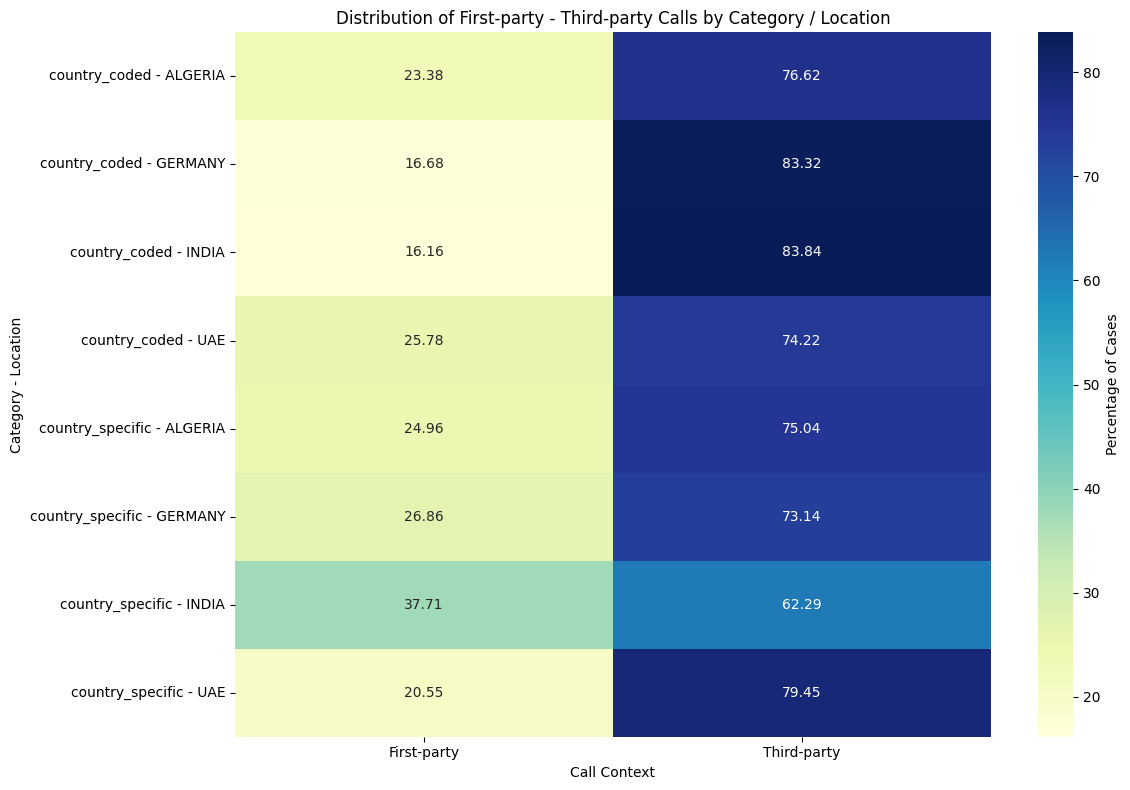

In [26]:
heatmap_data = call_context_percent_df.copy()
heatmap_data['Category - Location'] = heatmap_data['category'] + ' - ' + heatmap_data['location']
heatmap_data = heatmap_data.set_index('Category - Location')[['First-party', 'Third-party']]

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Percentage of Cases'})
plt.title('Distribution of First-party - Third-party Calls by Category / Location')
plt.ylabel('Category - Location')
plt.xlabel('Call Context')
plt.tight_layout()
plt.show()


**a. Country-coded sites**
- **23–25% of UIDs are first-party**, while **75–77% are third-party** across ALGERIA, GERMANY, INDIA, and UAE.  

**b. Country-specific sites**
- Mixed pattern:  
  - **ALGERIA:** High first-party proportion (**86.88%**).  
  - **INDIA:** Moderate first-party share (**30.84%**).  
  - **GERMANY and UAE:** Heavily third-party-driven (**75–80%**).  


### Statistical test -- Effect of country / bucket on the distribution of First-party / third-party

In [27]:
# -------------------------
# 1. Effect of Location
# -------------------------
# Contingency table: rows = locations, columns = call_context
location_table = id_df.groupby('location')['call_context'].value_counts().unstack(fill_value=0)

print("=== Effect of Location ===")
print("Testing whether the distribution of First-party vs Third-party calls differs by location.")
print("\nContingency table:")
print(location_table)

chi2_loc, p_loc, dof_loc, expected_loc = chi2_contingency(location_table)

print(f"\nChi-square statistic = {chi2_loc:.2f}, Degrees of freedom = {dof_loc}, p-value = {p_loc:.4e}")
if p_loc < 0.05:
    print("Interpretation: Significant difference in call context distribution across locations (reject H0).")
else:
    print("Interpretation: No significant difference across locations (fail to reject H0).")
print("\n" + "-"*60 + "\n")

# -------------------------
# 2. Effect of Category
# -------------------------
# Contingency table: rows = categories, columns = call_context
category_table = id_df.groupby('category')['call_context'].value_counts().unstack(fill_value=0)

print("=== Effect of Category ===")
print("Testing whether the distribution of First-party vs Third-party calls differs by category.")
print("\nContingency table:")
print(category_table)

chi2_cat, p_cat, dof_cat, expected_cat = chi2_contingency(category_table)

print(f"\nChi-square statistic = {chi2_cat:.2f}, Degrees of freedom = {dof_cat}, p-value = {p_cat:.4e}")
if p_cat < 0.05:
    print("Interpretation: Significant difference in call context distribution across categories (reject H0).")
else:
    print("Interpretation: No significant difference across categories (fail to reject H0).")
print("\n" + "-"*60 + "\n")

# -------------------------
# 3. Effect of Location × Category Interaction
# -------------------------
# Contingency table: rows = (category, location), columns = call_context
interaction_table = id_df.groupby(['category','location'])['call_context'].value_counts().unstack(fill_value=0)

print("=== Effect of Location × Category Interaction ===")
print("Testing whether the distribution of First-party vs Third-party calls differs when considering both location and category together.")
print("\nContingency table:")
print(interaction_table)

chi2_inter, p_inter, dof_inter, expected_inter = chi2_contingency(interaction_table)

print(f"\nChi-square statistic = {chi2_inter:.2f}, Degrees of freedom = {dof_inter}, p-value = {p_inter:.4e}")
if p_inter < 0.05:
    print("Interpretation: Significant interaction effect (distribution depends on both location and category).")
else:
    print("Interpretation: No significant interaction effect (distribution does not depend on the combination).")


=== Effect of Location ===
Testing whether the distribution of First-party vs Third-party calls differs by location.

Contingency table:
call_context  First-party  Third-party
location                              
ALGERIA             23541         4459
GERMANY            146017       452690
INDIA               77462       194797
UAE                 42333       156051

Chi-square statistic = 52426.10, Degrees of freedom = 3, p-value = 0.0000e+00
Interpretation: Significant difference in call context distribution across locations (reject H0).

------------------------------------------------------------

=== Effect of Category ===
Testing whether the distribution of First-party vs Third-party calls differs by category.

Contingency table:
call_context      First-party  Third-party
category                                  
country_coded          112061       351483
country_specific       177292       456514

Chi-square statistic = 1988.69, Degrees of freedom = 1, p-value = 0.0000e+00
In

#### **Printing few examples**

In [28]:
def format_example(row):
    return f'UID created by "{row["caller_url"]}" when visiting "{row["url"]}" ({row["call_context"]}, {row["category"]} - {row["location"]})'

first_party_examples = id_df[id_df['call_context'] == 'First-party'].groupby(
    ['category','location']
).first().reset_index()  # take first row per group

first_party_examples['example'] = first_party_examples.apply(format_example, axis=1)

third_party_examples = id_df[id_df['call_context'] == 'Third-party'].groupby(
    ['category','location']
).first().reset_index()

third_party_examples['example'] = third_party_examples.apply(format_example, axis=1)

print("=== First-party examples ===")
print()

for idx, row in first_party_examples.iterrows():
    print(format_example(row))
    print()

print("\n=== Third-party examples ===")

print()
for idx, row in third_party_examples.iterrows():
    print(format_example(row))
    print()
    

=== First-party examples ===

UID created by "https://kiabi.dz/cdn/shopifycloud/shop-js/client.js" when visiting "https://kiabi.dz/pages/programme-de-fidelite" (First-party, country_coded - ALGERIA)

UID created by "https://www.alma-solarshop.de/themes/akira-child-theme/assets/cache/bottom-938ab9869.js" when visiting "https://www.alma-solarshop.de//#" (First-party, country_coded - GERMANY)

UID created by "https://www.image.edu.in/js/modernizr.js" when visiting "https://www.image.edu.in/image-opens-new-centre-dilsukhnagar-2025.asp" (First-party, country_coded - INDIA)

UID created by "https://www.autoeurope.ae/dist/1.0.681/AE3/js/AE.general.min.js?cb=7wjUEy3zqFOKZu3l7ALn-681" when visiting "https://www.autoeurope.ae/%D8%B4%D8%B1%D8%AD-%D8%AA%D9%83%D8%A7%D9%84%D9%8A%D9%81-%D8%AA%D8%A7%D8%AC%D9%8A%D8%B1-%D8%A7%D9%84%D8%B3%D9%8A%D8%A7%D8%B1%D8%A7%D8%AA/" (First-party, country_coded - UAE)

UID created by "http://elearning.cu-barika.dz/lib/requirejs.php/1729083593/core/first.js" when visit

## 4.2 Most common third parties

#### *Considering only third-party user identification*

In [29]:
def caller_domains_with_percentages(group, field_to_consider):
    total = len(group)
    top_domains = group[field_to_consider].value_counts().reset_index()
    top_domains.columns = [field_to_consider, 'count']
    top_domains['count'] = pd.to_numeric(top_domains['count'], errors='coerce')
    top_domains['percentage'] = (top_domains['count'] / total * 100).round(2)
    # Format as "domain (xx.xx%)"
    top_domains['formatted'] = top_domains[field_to_consider] + ' (' + top_domains['percentage'].astype(str) + '%)'
    return list(top_domains['formatted'])


third_party_df = id_df[id_df['call_context'] == 'Third-party'].copy()
third_party_df['category_location'] = third_party_df['category'] + '-' + third_party_df['location']



full_result = third_party_df.groupby('category_location').apply(caller_domains_with_percentages, field_to_consider = 'caller_origin', include_groups=False).reset_index()
full_result.columns = ['Category-Location', 'Caller Domains with Percentages']

df_third_party_domains = pd.DataFrame({
    col: pd.Series(full_result[full_result['Category-Location'] == col]['Caller Domains with Percentages'].values[0])
    for col in full_result['Category-Location']
})

# Show top 20 rows

print('Top third party origins that create UIDs:')

print()

df_third_party_domains.head(20)


Top third party origins that create UIDs:



country_coded-ALGERIA  \
0           www.googletagmanager.com (20.8%)   
1                   www.gstatic.com (11.72%)   
2              connect.facebook.net (10.45%)   
3                     www.youtube.com (9.4%)   
4              js-agent.newrelic.com (4.01%)   
5                   cdn.cookielaw.org (3.7%)   
6                    s.go-mpulse.net (3.38%)   
7                   cdn.moengage.com (3.17%)   
8                     snap.licdn.com (2.75%)   
9                static.zdassets.com (2.64%)   
10                     sc-static.net (2.64%)   
11                      bat.bing.com (2.32%)   
12               assets.adobedtm.com (2.11%)   
13  ressource.gdpr-banner.awsmpsa.com (1.9%)   
14               www.redditstatic.com (1.8%)   
15    securepubads.g.doubleclick.net (1.69%)   
16          www.google-analytics.com (1.69%)   
17                 static.criteo.net (1.58%)   
18        ef-enterprise.oriserve.com (1.48%)   
19           cdn-eu.dynamicyield.com (1.48%)   

                     country_coded-GERMANY  \
0        www.googletagmanager.com (11.14%)   
1             connect.facebook.net (6.21%)   
2                     bat.bing.com (2.43%)   
3      static-tracking.klaviyo.com (2.22%)   
4                     s.pinimg.com (2.07%)   
5                 cdn.doofinder.com (1.9%)   
6                  www.gstatic.com (1.79%)   
7               static.klaviyo.com (1.77%)   
8                script.hotjar.com (1.63%)   
9            static.cleverpush.com (1.63%)   
10             static.zdassets.com (1.47%)   
11  securepubads.g.doubleclick.net (1.44%)   
12                   sc-static.net (1.36%)   
13                 cdn.shopify.com (1.23%)   
14           js-agent.newrelic.com (1.12%)   
15               cdn.cookielaw.org (1.03%)   
16                  tags.tiqcdn.com (1.0%)   
17                 cdn.id5-sync.com (0.9%)   
18                 cdn.taboola.com (0.88%)   
19                   www.dwin1.com (0.88%)   

                        country_coded-INDIA  \
0         www.googletagmanager.com (10.61%)   
1             www.zohowebstatic.com (6.93%)   
2               connect.facebook.net (5.0%)   
3                   www.youtube.com (4.35%)   
4                   cdn.pagesense.io (4.3%)   
5   zohotagmanager.cdn.pagesense.io (3.92%)   
6           widgets.zohosalesiq.com (2.65%)   
7                   www.gstatic.com (2.46%)   
8                   cdn.shopify.com (2.44%)   
9              sr-cdn.shiprocket.in (2.26%)   
10    pagead2.googlesyndication.com (1.92%)   
11                   js.zohocdn.com (1.68%)   
12                    sc-static.net (1.44%)   
13                  tags.tiqcdn.com (1.22%)   
14                     bat.bing.com (1.18%)   
15         static-assets.travix.com (1.13%)   
16                    snap.licdn.com (1.1%)   
17                     mc.yandex.ru (1.05%)   
18   securepubads.g.doubleclick.net (1.05%)   
19               static.zohocdn.com (0.97%)   

                                 country_coded-UAE  \
0                www.googletagmanager.com (21.29%)   
1                      connect.facebook.net (6.9%)   
2                            sc-static.net (5.81%)   
3                     livechat.infobip.com (2.93%)   
4                          cdn.shopify.com (2.78%)   
5                        checkout.tabby.ai (2.68%)   
6                             mc.yandex.ru (2.53%)   
7                      static.zdassets.com (2.18%)   
8                        script.hotjar.com (2.14%)   
9                          cdn.userway.org (2.02%)   
10                       cdn.cquotient.com (1.84%)   
11                         www.gstatic.com (1.83%)   
12                          snap.licdn.com (1.82%)   
13             siteintercept.qualtrics.com (1.73%)   
14           d157sasavg42st.cloudfront.net (1.51%)   
15                             bat.bing.com (1.5%)   
16                         cdn.moengage.com (1.4%)   
17  livesearch-autocomplete.magento-ds.com (1.01%)   
18                    cdn.quantum

In [33]:
def top_third_parties_by_storage(id_df, storage_column, category_name):
    
    # Filter by category, storage type, and third-party events
    df = id_df[
        (id_df['category'] == category_name) & 
        (id_df[storage_column]) & 
        (id_df['call_context'] == 'Third-party')
    ].copy()
    
    if df.empty:
        return pd.DataFrame()
    
    # Compute number of unique sites (etlds) per third-party per country
    etld_counts = (
        df.groupby(['location', 'caller_origin'])['etld']
        .nunique()
        .reset_index(name='site_count')
    )
    
    # Total unique sites per location
    total_sites = df.groupby('location')['etld'].nunique().reset_index(name='total_sites')
    
    # Merge and compute fraction of sites where third-party creates UID
    etld_counts = etld_counts.merge(total_sites, on='location')
    etld_counts['fraction'] = etld_counts['site_count'] / etld_counts['total_sites']
    
    # Sort and keep top 20 per country
    top_df = (
        etld_counts.sort_values(['location', 'fraction'], ascending=[True, False])
        .groupby('location')
        .head(20)
        .copy()
    )
    
    # Format for display
    top_df['formatted'] = top_df['caller_origin'] + ' (' + (top_df['fraction'] * 100).round(2).astype(str) + '%)'
    top_df['rank'] = top_df.groupby('location').cumcount() + 1
    
    # Pivot to wide format: one column per location
    pivoted_df = top_df.pivot(index='rank', columns='location', values='formatted')
    
    return pivoted_df

# Example usage for cookies, local storage, and session storage
top_cookies_coded = top_third_parties_by_storage(id_df, 'is_cookies_storage', 'country_coded')
top_cookies_specific = top_third_parties_by_storage(id_df, 'is_cookies_storage', 'country_specific')

top_local_storage_coded = top_third_parties_by_storage(id_df, 'is_local_storage', 'country_coded')
top_local_storage_specific = top_third_parties_by_storage(id_df, 'is_local_storage', 'country_specific')

top_session_storage_coded = top_third_parties_by_storage(id_df, 'is_session_storage', 'country_coded')
top_session_storage_specific = top_third_parties_by_storage(id_df, 'is_session_storage', 'country_specific')


print("Top third-party orgins setting cookies UIDs for country-coded bucket:")
display(top_cookies_coded.head(20))
print("Top third-party orgins setting cookies UIDs for country-specific bucket:")
display(top_cookies_specific.head(20))


print("Top third-party orgins setting local storage UIDs for country-coded bucket:")
display(top_local_storage_coded.head(20))
print("Top third-party orgins setting local storage UIDs for country-specific bucket:")
display(top_local_storage_specific.head(20))


print("Top third-party orgins setting session storage UIDs for country-coded bucket:")
display(top_session_storage_coded.head(20))
print("Top third-party orgins setting session storage UIDs for country-specific bucket:")
display(top_session_storage_specific.head(20))



Top third-party orgins setting cookies UIDs for country-coded bucket:


location                            ALGERIA  \
rank                                          
1                cdn.cookielaw.org (31.58%)   
2         www.googletagmanager.com (21.05%)   
3                  s.go-mpulse.net (15.79%)   
4         www.google-analytics.com (15.79%)   
5             cdn.tagcommander.com (10.53%)   
6             connect.facebook.net (10.53%)   
7                     stats.wp.com (10.53%)   
8               assets.adobedtm.com (5.26%)   
9                      bat.bing.com (5.26%)   
10          cdn-eu.dynamicyield.com (5.26%)   
11                 cdn.moengage.com (5.26%)   
12                    js.stripe.com (5.26%)   
13                    sc-static.net (5.26%)   
14             www.redditstatic.com (5.26%)   
15                                      NaN   
16                                      NaN   
17                                      NaN   
18                                      NaN   
19                                      NaN   
20                                      NaN   

location                                   GERMANY  \
rank                                                 
1                       cdn.cookielaw.org (19.13%)   
2                             s.pinimg.com (8.55%)   
3                 www.googletagmanager.com (6.65%)   
4                            sc-static.net (5.83%)   
5                     lantern.roeyecdn.com (5.64%)   
6                             bat.bing.com (4.12%)   
7                          s.go-mpulse.net (3.48%)   
8                            js.stripe.com (3.36%)   
9                  js-eu1.hs-analytics.net (3.17%)   
10                    apps.bazaarvoice.com (2.91%)   
11                    connect.facebook.net (2.79%)   
12                       cdn.cquotient.com (2.09%)   
13                           embed.tawk.to (2.09%)   
14                 cdn-ukwest.onetrust.com (1.96%)   
15                       sibautomation.com (1.96%)   
16                     js.hs-analytics.net (1.71%)   
17                          squeezely.tech (1.65%)   
18                         tags.tiqcdn.com (1.58%)   
19                    analytics.tiktok.com (1.52%)   
20        policy.app.cookieinformation.com (1.52%)   

location                              INDIA  \
rank                                          
1         www.googletagmanager.com (16.55%)   
2                     embed.tawk.to (9.01%)   
3                  cdn.cookielaw.org (8.9%)   
4                    img1.wsimg.com (8.33%)   
5              connect.facebook.net (4.95%)   
6          www.google-analytics.com (4.95%)   
7                  cdn.pagesense.io (4.62%)   
8                     sc-static.net (4.17%)   
9           widgets.zohosalesiq.com (4.05%)   
10               tags.crwdcntrl.net (3.72%)   
11                   s.go-mpulse.net (3.6%)   
12                 cdn.moengage.com (2.14%)   
13              assets.adobedtm.com (1.91%)   
14                     bat.bing.com (1.91%)   
15                       c.adsco.re (1.91%)   
16              cdn-in.pagesense.io (1.91%)   
17              js.hs-analytics.net (1.91%)   
18                     stats.wp.com (1.91%)   
19             checkout.razorpay.com (1.8%)   
20           static.cdninstagram.com (1.8%)   

location                                      UAE  
rank                                               
1                          sc-static.net (31.98%)  
2                           embed.tawk.to (9.59%)  
3                       cdn.cookielaw.org (8.14%)  
4                       checkout.tabby.ai (7.85%)  
5                            js.stripe.com (6.1%)  
6                www.googletagmanager.com (5.81%)  
7                       cdn.cquotient.com (5.23%)  
8                         s.go-mpulse.net (4.65%)  
9         www.datadoghq-browser-agent.com (3.78%)  
10                js-eu1.hs-analytics.net (3.49%)  
11                cdn-eu.dynamicyield.com (2.62%)  
12                           s.pinimg.com (2.62%)  
13           

Top third-party orgins setting cookies UIDs for country-specific bucket:


location                                ALGERIA  \
rank                                              
1              www.googletagmanager.com (48.7%)   
2             www.google-analytics.com (20.87%)   
3                         stats.wp.com (10.43%)   
4                          embed.tawk.to (8.7%)   
5                  connect.facebook.net (7.83%)   
6                       c.disquscdn.com (4.35%)   
7                      d-code.liadm.com (4.35%)   
8               js-eu1.hs-analytics.net (4.35%)   
9                     cdn.cookielaw.org (2.61%)   
10                      load.sumome.com (2.61%)   
11                      cdn.pushowl.com (1.74%)   
12                        js.stripe.com (1.74%)   
13        pagead2.googlesyndication.com (1.74%)   
14               sawtalahrar.disqus.com (1.74%)   
15                        sc-static.net (1.74%)   
16                    sibautomation.com (1.74%)   
17            www.freeprivacypolicy.com (1.74%)   
18                  accounts.google.com (0.87%)   
19                    app.getbeamer.com (0.87%)   
20                            c0.wp.com (0.87%)   

location                                 GERMANY  \
rank                                               
1              www.googletagmanager.com (13.38%)   
2                           s.pinimg.com (7.41%)   
3                      cdn.cookielaw.org (6.97%)   
4                   cdn.privacy-mgmt.com (6.22%)   
5                           a.amxrtb.com (5.66%)   
6                   lantern.roeyecdn.com (5.29%)   
7                   connect.facebook.net (4.98%)   
8                     tags.crwdcntrl.net (4.29%)   
9                 cdn.consentmanager.net (4.17%)   
10         static-eu.payments-amazon.com (3.98%)   
11                          bat.bing.com (3.61%)   
12                      sibautomation.com (3.3%)   
13              www.google-analytics.com (3.11%)   
14               js-eu1.hs-analytics.net (2.68%)   
15        securepubads.g.doubleclick.net (2.49%)   
16          pagead2.googlesyndication.com (2.3%)   
17                         sc-static.net (2.05%)   
18                       tags.tiqcdn.com (2.05%)   
19                        cdn.cxense.com (1.93%)   
20                         js.stripe.com (1.87%)   

location                                   INDIA  \
rank                                               
1              www.googletagmanager.com (57.18%)   
2              www.google-analytics.com (19.55%)   
3                  connect.facebook.net (14.76%)   
4          pagead2.googlesyndication.com (8.11%)   
5                          embed.tawk.to (3.52%)   
6                         img1.wsimg.com (3.32%)   
7                          sc-static.net (3.23%)   
8             fastrr-boost-ui.pickrr.com (2.83%)   
9                       cdn.jsdelivr.net (2.74%)   
10                         pdp.gokwik.co (2.64%)   
11                    tags.crwdcntrl.net (2.64%)   
12         d2r1yp2w7bby2u.cloudfront.net (2.44%)   
13                         app.wigzo.com (2.25%)   
14                 checkout.razorpay.com (2.25%)   
15                          stats.wp.com (2.15%)   
16                          bat.bing.com (2.05%)   
17        securepubads.g.doubleclick.net (1.86%)   
18                      cdn.moengage.com (1.66%)   
19                       cdn.shopify.com (1.37%)   
20                       s.go-mpulse.net (1.37%)   

location                                UAE  
rank                                         
1                    sc-static.net (23.03%)  
2                    embed.tawk.to (17.56%)  
3         www.googletagmanager.com (10.88%)  
4                     js.stripe.com (6.01%)  
5                    img1.wsimg.com (5.27%)  
6                      stats.wp.com (5.01%)  
7              connect.facebook.net (4.27%)  
8               js.hs-analytics.net (3.67%)  
9             static.parastorage.com (2.6%)  
10                checkout.tabby.ai (2.54%)  
11         www.google-analytics.com

Top third-party orgins setting local storage UIDs for country-coded bucket:


location                                          ALGERIA  \
rank                                                        
1                                www.youtube.com (33.33%)   
2                           connect.facebook.net (20.51%)   
3                       www.googletagmanager.com (20.51%)   
4                                www.gstatic.com (20.51%)   
5                                 snap.licdn.com (10.26%)   
6                           js-agent.newrelic.com (7.69%)   
7               ressource.gdpr-banner.awsmpsa.com (7.69%)   
8                                 s.go-mpulse.net (7.69%)   
9                        www.youtube-nocookie.com (7.69%)   
10                            assets.adobedtm.com (5.13%)   
11                                   bat.bing.com (5.13%)   
12                 securepubads.g.doubleclick.net (5.13%)   
13                        cdn-eu.dynamicyield.com (2.56%)   
14                               cdn.moengage.com (2.56%)   
15                                 cdn.weglot.com (2.56%)   
16                                  code.tidio.co (2.56%)   
17                  d3ulwu8fab47va.cloudfront.net (2.56%)   
18                     ef-enterprise.oriserve.com (2.56%)   
19        legrand-plateforme.containers.piwik.pro (2.56%)   
20                           munchkin.marketo.net (2.56%)   

location                                 GERMANY  \
rank                                               
1              www.googletagmanager.com (40.62%)   
2                   connect.facebook.net (35.4%)   
3                          bat.bing.com (19.93%)   
4                       www.gstatic.com (16.44%)   
5                       www.youtube.com (10.76%)   
6                     script.hotjar.com (10.14%)   
7                           s.pinimg.com (8.86%)   
8            static-tracking.klaviyo.com (6.76%)   
9                           www.dwin1.com (6.1%)   
10                 consent.cookiebot.com (5.99%)   
11                    static.klaviyo.com (5.89%)   
12                 js-agent.newrelic.com (5.48%)   
13                        snap.licdn.com (5.43%)   
14                    dynamic.criteo.com (5.23%)   
15        securepubads.g.doubleclick.net (5.17%)   
16                         sc-static.net (4.92%)   
17              www.youtube-nocookie.com (4.71%)   
18                   static.zdassets.com (4.35%)   
19                     cdn.doofinder.com (3.69%)   
20                       cdn.shopify.com (3.69%)   

location                                    INDIA  \
rank                                                
1                www.googletagmanager.com (27.2%)   
2                        www.youtube.com (26.89%)   
3                   connect.facebook.net (20.53%)   
4                        www.gstatic.com (16.74%)   
5                          snap.licdn.com (8.86%)   
6                    sr-cdn.shiprocket.in (6.82%)   
7           pagead2.googlesyndication.com (6.36%)   
8                         cdn.shopify.com (5.23%)   
9                            bat.bing.com (4.77%)   
10                         js.zohocdn.com (4.32%)   
11                      script.hotjar.com (4.09%)   
12         securepubads.g.doubleclick.net (4.02%)   
13                           mc.yandex.ru (3.64%)   
14        zohotagmanager.cdn.pagesense.io (3.33%)   
15                     tags.crwdcntrl.net (3.26%)   
16                widgets.zohosalesiq.com (3.26%)   
17                  www.zohowebstatic.com (3.18%)   
18                        cdn.pagesense.io (2.8%)   
19                          sc-static.net (2.42%)   
20                    assets.adobedtm.com (2.35%)   

location                                  UAE  
rank                                           
1           www.googletagmanager.com (52.16%)  
2                connect.facebook.net (40.0%)  
3                    www.gstatic.com (23.71%)  
4                      sc-static.net (22.06%)  
5                     snap.licdn.com (15.67%)  
6        

Top third-party orgins setting local storage UIDs for country-specific bucket:


location                                ALGERIA  \
rank                                              
1                      www.youtube.com (46.55%)   
2                      www.gstatic.com (36.64%)   
3                  connect.facebook.net (6.03%)   
4         pagead2.googlesyndication.com (4.31%)   
5              www.googletagmanager.com (3.88%)   
6                       c.disquscdn.com (2.59%)   
7                         code.tidio.co (2.16%)   
8                      d-code.liadm.com (2.16%)   
9                       cdn.taboola.com (1.72%)   
10               eus.rubiconproject.com (1.72%)   
11                  vidstat.taboola.com (1.72%)   
12                      cdn.pushowl.com (0.86%)   
13                        e.dtscout.com (0.86%)   
14                        embed.tawk.to (0.86%)   
15                      p.mrktmtrcs.net (0.86%)   
16               sawtalahrar.disqus.com (0.86%)   
17                        sc-static.net (0.86%)   
18                       snap.licdn.com (0.86%)   
19                   tags.crwdcntrl.net (0.86%)   
20             www.youtube-nocookie.com (0.86%)   

location                                  GERMANY  \
rank                                                
1               www.googletagmanager.com (27.22%)   
2                   connect.facebook.net (23.19%)   
3                           bat.bing.com (14.56%)   
4         securepubads.g.doubleclick.net (14.52%)   
5                       cdn.id5-sync.com (11.71%)   
6                      tags.crwdcntrl.net (9.35%)   
7                          www.gstatic.com (8.8%)   
8                   c.amazon-adsystem.com (8.17%)   
9                  cdn.consentmanager.net (8.03%)   
10               secure.cdn.fastclick.net (7.89%)   
11                       static.criteo.net (7.8%)   
12               www.youtube-nocookie.com (7.44%)   
13                   cdn.privacy-mgmt.com (7.08%)   
14                        www.youtube.com (6.35%)   
15                         script.4dex.io (6.22%)   
16                        cdn.taboola.com (6.17%)   
17          pagead2.googlesyndication.com (5.85%)   
18                 eus.rubiconproject.com (5.49%)   
19                      cdn.doofinder.com (5.26%)   
20                           s.pinimg.com (5.26%)   

location                                      INDIA  \
rank                                                  
1                 www.googletagmanager.com (36.21%)   
2            pagead2.googlesyndication.com (24.25%)   
3                     connect.facebook.net (22.46%)   
4                          www.gstatic.com (10.76%)   
5                           cdn.shopify.com (8.71%)   
6                      sr-cdn.shiprocket.in (7.94%)   
7                           www.youtube.com (7.86%)   
8            securepubads.g.doubleclick.net (6.32%)   
9                            snap.licdn.com (6.06%)   
10                           cdn.izooto.com (5.38%)   
11                            pdp.gokwik.co (5.38%)   
12                     checkout.razorpay.com (4.7%)   
13                          cdn.taboola.com (4.61%)   
14                             bat.bing.com (4.44%)   
15                         cdn.onesignal.com (3.5%)   
16                    js-agent.newrelic.com (3.25%)   
17                         cdn.jsdelivr.net (3.07%)   
18                       tags.crwdcntrl.net (3.07%)   
19                        script.hotjar.com (2.99%)   
20        checkout-static-next.razorpay.com (2.73%)   

location                                    UAE  
rank                                             
1             www.googletagmanager.com (39.96%)  
2                       www.gstatic.com (32.1%)  
3                 connect.facebook.net (30.45%)  
4                         sc-static.net (15.0%)  
5                      www.youtube.com (14.22%)  
6                       snap.licdn.com (13.76%)  
7                          mc.yandex.ru (8.18%)  
8                     script.hotjar.com (5.76%)  

Top third-party orgins setting session storage UIDs for country-coded bucket:


location                        ALGERIA                              GERMANY  \
rank                                                                           
1              www.gstatic.com (55.56%)        connect.facebook.net (28.05%)   
2         connect.facebook.net (16.67%)             www.gstatic.com (18.84%)   
3              www.youtube.com (11.11%)        analytics.tiktok.com (15.07%)   
4           assets.adobedtm.com (5.56%)             www.youtube.com (14.99%)   
5                cdn.weglot.com (5.56%)                s.pinimg.com (10.87%)   
6           maps.googleapis.com (5.56%)             script.hotjar.com (7.8%)   
7                                   NaN     www.youtube-nocookie.com (5.26%)   
8                                   NaN          tags.creativecdn.com (5.0%)   
9                                   NaN              cdn.taboola.com (4.21%)   
10                                  NaN  static-tracking.klaviyo.com (4.21%)   
11                                  NaN           static.klaviyo.com (3.68%)   
12                                  NaN            cdn.cookielaw.org (3.24%)   
13                                  NaN            cdn.doofinder.com (2.89%)   
14                                  NaN                sc-static.net (2.72%)   
15                                  NaN          accounts.google.com (2.28%)   
16                                  NaN          pixel.byspotify.com (2.19%)   
17                                  NaN          assets.adobedtm.com (1.93%)   
18                                  NaN            cdn.cquotient.com (1.93%)   
19                                  NaN          static.zdassets.com (1.84%)   
20                                  NaN          script.crazyegg.com (1.75%)   

location                                    INDIA  \
rank                                                
1                        www.youtube.com (38.79%)   
2                        www.gstatic.com (24.18%)   
3                    connect.facebook.net (9.57%)   
4                 widgets.zohosalesiq.com (5.42%)   
5                  static.parastorage.com (5.04%)   
6              fastrr-boost-ui.pickrr.com (2.02%)   
7                           sc-static.net (1.76%)   
8                         cdn.shopify.com (1.64%)   
9                     accounts.google.com (1.51%)   
10                    assets.adobedtm.com (1.51%)   
11               www.youtube-nocookie.com (1.51%)   
12                    maps.googleapis.com (1.39%)   
13                      script.hotjar.com (1.26%)   
14                        salesiq.zoho.in (1.13%)   
15                      cdn.cookielaw.org (1.01%)   
16                        cdn.taboola.com (1.01%)   
17                     edge.fullstory.com (1.01%)   
18        images-eu.ssl-images-amazon.com (1.01%)   
19                     m.media-amazon.com (0.88%)   
20                        s.go-mpulse.net (0.88%)   

location                                      UAE  
rank                                               
1                   connect.facebook.net (40.71%)  
2                   analytics.tiktok.com (31.23%)  
3                        www.gstatic.com (27.27%)  
4                          sc-static.net (11.46%)  
5                      maps.googleapis.com (8.3%)  
6                       script.hotjar.com (6.72%)  
7                  static.parastorage.com (6.32%)  
8                            s.pinimg.com (4.35%)  
9                     accounts.google.com (3.56%)  
10        images-eu.ssl-images-amazon.com (3.56%)  
11                      cdn.cquotient.com (3.16%)  
12                        cdn.userway.org (3.16%)  
13                     m.media-amazon.com (2.77%)  
14                   tags.creativecdn.com (2.77%)  
15                  cdn.quantummetric.com (2.37%)  
16                        cdn.shopify.com (2.37%)  
17            siteintercept.qualtrics.com (2.37%)  
18            static-tracking.klaviyo.com (2.37%)  
19                    assets.ado

Top third-party orgins setting session storage UIDs for country-specific bucket:


location                          ALGERIA  \
rank                                        
1                www.gstatic.com (76.98%)   
2                www.youtube.com (12.23%)   
3            connect.facebook.net (5.76%)   
4            analytics.tiktok.com (2.88%)   
5                 cdn.taboola.com (2.88%)   
6                       c0.wp.com (1.44%)   
7                 cdn.pushowl.com (1.44%)   
8                m.stripe.network (1.44%)   
9             maps.googleapis.com (1.44%)   
10            vidstat.taboola.com (1.44%)   
11                cdn.shopify.com (0.72%)   
12               cdn.webpushr.com (0.72%)   
13        js-eu1.hs-analytics.net (0.72%)   
14         static.parastorage.com (0.72%)   
15            static.xx.fbcdn.net (0.72%)   
16                                    NaN   
17                                    NaN   
18                                    NaN   
19                                    NaN   
20                                    NaN   

location                                 GERMANY  \
rank                                               
1                  connect.facebook.net (25.44%)   
2                       www.gstatic.com (15.35%)   
3                  analytics.tiktok.com (11.07%)   
4                          cdns.symplr.de (9.1%)   
5         client.aps.amazon-adsystem.com (8.11%)   
6                        cdn.taboola.com (7.89%)   
7            static-tracking.klaviyo.com (6.25%)   
8                      cdn.doofinder.com (6.03%)   
9                           s.pinimg.com (5.92%)   
10                     script.hotjar.com (5.81%)   
11                    static.klaviyo.com (5.48%)   
12                 c.amazon-adsystem.com (5.04%)   
13              www.youtube-nocookie.com (4.93%)   
14                          jsc.mgid.com (4.28%)   
15                       www.youtube.com (3.95%)   
16                 static.cleverpush.com (3.73%)   
17                  tags.creativecdn.com (3.07%)   
18                   maps.googleapis.com (2.74%)   
19                 consent.cookiebot.com (2.63%)   
20                        cdn.cxense.com (2.41%)   

location                                  INDIA  \
rank                                              
1                      www.gstatic.com (37.63%)   
2                 connect.facebook.net (15.86%)   
3                       cdn.shopify.com (8.87%)   
4             fastrr-boost-ui.pickrr.com (8.6%)   
5                       cdn.taboola.com (5.65%)   
6                         pdp.gokwik.co (5.65%)   
7                       www.youtube.com (5.38%)   
8                          jsc.mgid.com (2.96%)   
9                     script.hotjar.com (2.96%)   
10             osjs.netcoresmartech.com (2.69%)   
11        d2r1yp2w7bby2u.cloudfront.net (2.42%)   
12                        sc-static.net (2.15%)   
13                  accounts.google.com (1.88%)   
14             cdnt.netcoresmartech.com (1.88%)   
15                      s.go-mpulse.net (1.88%)   
16                 sr-cdn.shiprocket.in (1.88%)   
17                   kwikcart.gokwik.co (1.61%)   
18                         cdn.dotpe.in (1.34%)   
19                    cdn.onesignal.com (1.34%)   
20             script-api.ccgateway.net (1.34%)   

location                                       UAE  
rank                                                
1                         www.gstatic.com (43.41%)  
2                     connect.facebook.net (28.5%)  
3                    analytics.tiktok.com (16.49%)  
4                  static.parastorage.com (12.51%)  
5                            sc-static.net (4.72%)  
6                        script.hotjar.com (4.64%)  
7                      maps.googleapis.com (3.65%)  
8                         salesiq.zoho.com (2.73%)  
9                             mc.yandex.ru (2.15%)  
10                           embed.tawk.to (1.99%)  
11                  salesiq.zohopublic.com (1.99%)  
12                         cdn.taboola.com (1.66%)  

#### **Most common third-parties per country/bucket -- grouped by parent organization**

In [35]:
with open("resources/duckduckgo_domain_map.json") as f:
    radar_data = json.load(f)

domain_to_entity = {domain: info.get("displayName", "Unknown") for domain, info in radar_data.items()}

third_party_df['organization'] = third_party_df['caller_domain'].map(domain_to_entity).fillna("Unknown")

def top_orgs(group, top_n=20):
    total = len(group)
    top_entities = group['organization'].value_counts().reset_index()
    top_entities.columns = ['organization', 'count']
    top_entities['percentage'] = (top_entities['count'] / total * 100).round(2)
    top_entities['formatted'] = top_entities['organization'] + ' (' + top_entities['percentage'].astype(str) + '%)'
    return list(top_entities['formatted'])




top_orgs_result = third_party_df.groupby('category_location').apply(caller_domains_with_percentages, field_to_consider = 'organization', include_groups=False).reset_index()
top_orgs_result.columns = ['Category-Location', 'Top 20 Organizations']

df_top_orgs_wide = pd.DataFrame({
    col: pd.Series(top_orgs_result[top_orgs_result['Category-Location'] == col]['Top 20 Organizations'].values[0])
    for col in top_orgs_result['Category-Location']
})

df_top_orgs_wide.head(20)

country_coded-ALGERIA         country_coded-GERMANY  \
0         Google (46.36%)               Google (16.32%)   
1       Facebook (10.45%)              Unknown (13.48%)   
2         Unknown (5.17%)              Facebook (6.21%)   
3       Microsoft (5.07%)               Klaviyo (3.99%)   
4       New Relic (4.01%)             Microsoft (3.21%)   
5         OneTrust (3.7%)            Amazon.com (3.02%)   
6          Akamai (3.38%)             Pinterest (2.07%)   
7        MoEngage (3.17%)              Doofinder (1.9%)   
8            Snap (2.64%)            CleverPush (1.65%)   
9         Zendesk (2.64%)                Hotjar (1.63%)   
10          Adobe (2.43%)               Zendesk (1.51%)   
11          Reddit (1.8%)                  Snap (1.36%)   
12         Criteo (1.58%)                Criteo (1.32%)   
13  Dynamic Yield (1.48%)               Shopify (1.23%)   
14         Stripe (1.06%)              OneTrust (1.14%)   
15    Green Hills (1.06%)             New Relic (1.12%)   
16          Fjord (1.06%)         SMARTER CLICK (1.11%)   
17         Hotjar (0.84%)                Tealium (1.0%)   
18         Didomi (0.84%)  Travix International (0.98%)   
19     Amazon.com (0.63%)               Taboola (0.96%)   

             country_coded-INDIA       country_coded-UAE  \
0                   ZOHO (22.0%)         Google (24.83%)   
1                Google (21.69%)        Unknown (13.27%)   
2               Unknown (14.13%)        Facebook (6.91%)   
3               Facebook (5.17%)            Snap (5.81%)   
4              Microsoft (2.48%)       Microsoft (3.65%)   
5                Shopify (2.44%)      Amazon.com (3.53%)   
6              Amazon.com (1.9%)          Yandex (3.03%)   
7   Travix International (1.51%)         Infobip (2.93%)   
8                   Snap (1.44%)         Shopify (2.78%)   
9                 Yandex (1.28%)         Zendesk (2.18%)   
10               Tealium (1.22%)          Hotjar (2.14%)   
11             Amplitude (0.94%)  Salesforce.com (2.12%)   
12               MoEngage (0.9%)     Silver Lake (1.73%)   
13            LivePerson (0.88%)      Webklipper (1.46%)   
14              OneTrust (0.79%)         MoEngage (1.4%)   
15                 Adobe (0.77%)          Akamai (1.07%)   
16                Hotjar (0.75%)         Klaviyo (1.07%)   
17                Akamai (0.74%)   Quantum Metric (1.0%)   
18             FullStory (0.67%)  Trip.com Group (0.93%)   
19               Taboola (0.61%)       ByteDance (0.92%)   

   country_specific-ALGERIA  country_specific-GERMANY  \
0           Google (70.64%)           Google (14.52%)   
1        Cloudflare (7.06%)          Unknown (14.49%)   
2          Facebook (4.56%)        CleverPush (5.75%)   
3           Unknown (2.88%)        Amazon.com (5.28%)   
4            Disqus (2.11%)            Klaviyo (4.8%)   
5           HubSpot (1.96%)          Facebook (3.76%)   
6           Taboola (1.65%)               ID5 (3.73%)   
7              Snap (1.62%)        Conversant (2.59%)   
8       Green Hills (1.25%)           Taboola (2.18%)   
9        LiveIntent (1.08%)  Lotame Solutions (2.17%)   
10          Wix.com (0.88%)            Adagio (2.04%)   
11       Automattic (0.85%)          Microsoft (1.9%)   
12   Shashank Kumar (0.48%)       Sourcepoint (1.87%)   
13           Stripe (0.34%)         Permutive (1.49%)   
14        Microsoft (0.34%)           Shopify (1.43%)   
15         OneTrust (0.31%)    ConsentManager (1.41%)   
16          Magnite (0.28%)      Usercentrics (1.29%)   
17       Amazon.com (0.28%)    Piano Software (1.16%)   
18         ByteDance (0.2%)            HubSpot (1.1%)   
19          Bombora (0.14%)      BurdaForward (1.03%)   

       country_specific-INDIA                    country_specific-UAE  
0             Google (30.08%)                         Google (28.85%)  
1             Unknown (27.0%)                        Unknown (13.83%)  
2            Shopify (12.77%)                        Facebook (8.09%)  
3            Face

In [37]:
def top_organizations_by_storage(id_df, storage_column, category_name, radar_data):

    
    # Map each caller_origin to its parent organization
    def get_org(origin, domain):
        info = radar_data.get(origin) or radar_data.get(domain) or {}
        return info.get('displayName', 'Unknown')
    
    df = id_df[
        (id_df['category'] == category_name) & 
        (id_df[storage_column]) & 
        (id_df['call_context'] == 'Third-party')
    ].copy()
    
    if df.empty:
        return pd.DataFrame()
    
    df['organization'] = df.apply(lambda row: get_org(row['caller_origin'], row['caller_domain']), axis=1)
    
    # Count unique etlds per organization per location
    org_counts = (
        df.groupby(['location', 'organization'])['etld']
        .nunique()
        .reset_index(name='site_count')
    )
    
    # Total unique etlds per location
    total_sites = df.groupby('location')['etld'].nunique().reset_index(name='total_sites')
    
    # Merge and compute fraction
    org_counts = org_counts.merge(total_sites, on='location')
    org_counts['fraction'] = org_counts['site_count'] / org_counts['total_sites']
    
    # Sort and keep top 20 per location
    top_orgs = (
        org_counts.sort_values(['location', 'fraction'], ascending=[True, False])
        .groupby('location')
        .head(20)
        .copy()
    )
    
    # Format for display
    top_orgs['formatted'] = top_orgs['organization'] + ' (' + (top_orgs['fraction']*100).round(2).astype(str) + '%)'
    top_orgs['rank'] = top_orgs.groupby('location').cumcount() + 1
    
    # Pivot to wide format: one column per location
    pivoted_df = top_orgs.pivot(index='rank', columns='location', values='formatted')
    
    return pivoted_df


# Example usage for country_coded
top_cookies_orgs = top_organizations_by_storage(id_df, 'is_cookies_storage', 'country_coded', radar_data)
top_local_storage_orgs = top_organizations_by_storage(id_df, 'is_local_storage', 'country_coded', radar_data)
top_session_storage_orgs = top_organizations_by_storage(id_df, 'is_session_storage', 'country_coded', radar_data)


top_cookies_coded = top_organizations_by_storage(id_df, 'is_cookies_storage', 'country_coded', radar_data)
top_cookies_specific = top_organizations_by_storage(id_df, 'is_cookies_storage', 'country_specific', radar_data)

top_local_storage_coded = top_organizations_by_storage(id_df, 'is_local_storage', 'country_coded', radar_data)
top_local_storage_specific = top_organizations_by_storage(id_df, 'is_local_storage', 'country_specific', radar_data)

top_session_storage_coded = top_organizations_by_storage(id_df, 'is_session_storage', 'country_coded', radar_data)
top_session_storage_specific = top_organizations_by_storage(id_df, 'is_session_storage', 'country_specific', radar_data)




print("Top organizations setting cookies UIDs for country-coded bucket:")
display(top_cookies_coded.head(20))
print("Top organizations setting cookies UIDs for country-specific bucket:")
display(top_cookies_specific.head(20))


print("Top organizations setting local storage UIDs for country-coded bucket:")
display(top_local_storage_coded.head(20))
print("Top third-party orgins setting local storage UIDs for country-specific bucket:")
display(top_local_storage_specific.head(20))


print("Top organizations setting session storage UIDs for country-coded bucket:")
display(top_session_storage_coded.head(20))
print("Top organizations setting session storage UIDs for country-specific bucket:")
display(top_session_storage_specific.head(20))


Top organizations setting cookies UIDs for country-coded bucket:


location                ALGERIA                             GERMANY  \
rank                                                                  
1             OneTrust (31.58%)                    Unknown (29.45%)   
2               Google (21.05%)                   OneTrust (22.23%)   
3               Akamai (15.79%)                   Pinterest (8.55%)   
4           Automattic (10.53%)                      Google (7.92%)   
5             Facebook (10.53%)                        Snap (5.83%)   
6                Fjord (10.53%)                   Microsoft (5.57%)   
7                 Adobe (5.26%)                     HubSpot (4.94%)   
8         Dynamic Yield (5.26%)                      Akamai (3.74%)   
9             Microsoft (5.26%)                      Stripe (3.36%)   
10             MoEngage (5.26%)               Marlin Equity (3.29%)   
11               Reddit (5.26%)                  Amazon.com (3.17%)   
12                 Snap (5.26%)                    Facebook (2.85%)   
13               Stripe (5.26%)              Salesforce.com (2.28%)   
14                          NaN  Dual Technologies Services (1.96%)   
15                          NaN                       Adobe (1.65%)   
16                          NaN               Dynamic Yield (1.58%)   
17                          NaN                   Kameleoon (1.58%)   
18                          NaN                     Tealium (1.58%)   
19                          NaN                   ByteDance (1.52%)   
20                          NaN          Cookie Information (1.52%)   

location                     INDIA                     UAE  
rank                                                        
1                 Unknown (29.62%)           Snap (31.98%)  
2                  Google (19.14%)        Unknown (28.78%)  
3                 OneTrust (9.91%)       OneTrust (10.17%)  
4                Starfield (8.33%)           Google (6.1%)  
5                     ZOHO (6.87%)           Stripe (6.1%)  
6                 Facebook (6.76%)         HubSpot (5.52%)  
7                     Snap (4.17%)  Salesforce.com (5.52%)  
8                   Akamai (3.83%)          Akamai (5.23%)  
9         Lotame Solutions (3.72%)         Datadog (3.78%)  
10               Microsoft (2.93%)        Facebook (3.49%)  
11              Amazon.com (2.59%)       Microsoft (3.49%)  
12                 HubSpot (2.59%)   Dynamic Yield (2.91%)  
13                   Adobe (2.14%)       Pinterest (2.62%)  
14                MoEngage (2.14%)   Marlin Equity (2.33%)  
15              Automattic (2.03%)        MoEngage (2.33%)  
16                 Adscore (1.91%)         Shopify (2.33%)  
17          Salesforce.com (1.46%)      Amazon.com (2.03%)  
18                  Stripe (1.46%)        Omnisend (2.03%)  
19         Hue-Interactive (1.35%)  Quantum Metric (2.03%)  
20                 Shopify (1.24%)        TrustArc (2.03%)

Top organizations setting cookies UIDs for country-specific bucket:


location                             ALGERIA  \
rank                                           
1                            Google (56.52%)   
2                           Unknown (17.39%)   
3                        Automattic (10.43%)   
4                           Facebook (7.83%)   
5                            HubSpot (5.22%)   
6                             Disqus (4.35%)   
7                         LiveIntent (4.35%)   
8                           OneTrust (2.61%)   
9         Dual Technologies Services (1.74%)   
10                    Shashank Kumar (1.74%)   
11                              Snap (1.74%)   
12                            Stripe (1.74%)   
13                             Fjord (0.87%)   
14                         NitroPack (0.87%)   
15                           Wix.com (0.87%)   
16                                       NaN   
17                                       NaN   
18                                       NaN   
19                                       NaN   
20                                       NaN   

location                            GERMANY                     INDIA  \
rank                                                                    
1                          Unknown (30.93%)           Google (64.91%)   
2                           Google (19.54%)          Unknown (22.09%)   
3                          OneTrust (8.03%)         Facebook (15.44%)   
4                         Pinterest (7.41%)         Starfield (3.32%)   
5                       Sourcepoint (6.91%)              Snap (3.23%)   
6                      Monet Engine (5.66%)        Amazon.com (3.13%)   
7                        Amazon.com (5.29%)      Prospect One (2.74%)   
8                          Facebook (5.04%)  Lotame Solutions (2.64%)   
9                         Microsoft (4.85%)         Microsoft (2.64%)   
10                 Lotame Solutions (4.29%)   Hue-Interactive (2.25%)   
11                   ConsentManager (4.17%)        Automattic (2.15%)   
12        Dual Technologies Services (3.3%)          MoEngage (1.66%)   
13                          HubSpot (3.17%)            Akamai (1.37%)   
14                   Piano Software (2.68%)            Hotjar (1.37%)   
15                        Permutive (2.24%)           Shopify (1.37%)   
16                          Tealium (2.12%)         Chartbeat (1.27%)   
17                             Snap (2.05%)              ZOHO (0.98%)   
18                           Stripe (1.87%)          comScore (0.98%)   
19                         Yieldlove (1.8%)             Adobe (0.88%)   
20                         etracker (1.62%)          OneTrust (0.78%)   

location                  UAE  
rank                           
1            Unknown (31.64%)  
2               Snap (23.03%)  
3             Google (11.62%)  
4              Stripe (6.01%)  
5             HubSpot (5.94%)  
6            Facebook (5.87%)  
7           Starfield (5.27%)  
8          Automattic (5.01%)  
9                ZOHO (4.74%)  
10          Microsoft (2.67%)  
11             Wix.com (2.6%)  
12          ByteDance (1.54%)  
13            OneTrust (1.4%)  
14          Amazon.com (1.2%)  
15            Omnisend (1.2%)  
16                ecpm (1.0%)  
17        B-Analytics (0.87%)  
18             Reddit (0.87%)  
19            Shopify (0.87%)  
20             Akamai (0.73%)

Top organizations setting local storage UIDs for country-coded bucket:


location                 ALGERIA               GERMANY  \
rank                                                     
1                Google (79.49%)       Google (69.83%)   
2              Facebook (20.51%)      Unknown (38.88%)   
3               Unknown (15.38%)      Facebook (35.4%)   
4             Microsoft (12.82%)    Microsoft (23.16%)   
5                 Akamai (7.69%)       Hotjar (10.14%)   
6              New Relic (7.69%)  Usercentrics (9.78%)   
7                  Adobe (5.13%)    Amazon.com (9.73%)   
8             Amazon.com (2.56%)     Pinterest (8.86%)   
9                 Criteo (2.56%)        Criteo (8.25%)   
10                Didomi (2.56%)       Klaviyo (7.22%)   
11         Dynamic Yield (2.56%)           Awin (6.1%)   
12           Green Hills (2.56%)     New Relic (5.48%)   
13                Hotjar (2.56%)          Snap (4.92%)   
14              MoEngage (2.56%)       Zendesk (4.35%)   
15             Piwik PRO (2.56%)      RTB House (4.2%)   
16                Reddit (2.56%)     Doofinder (3.69%)   
17        Salesforce.com (2.56%)       Shopify (3.69%)   
18                  Snap (2.56%)        PayPal (3.33%)   
19               Zendesk (2.56%)       Taboola (3.33%)   
20                           NaN        Akamai (3.28%)   

location                     INDIA                     UAE  
rank                                                        
1                  Google (71.44%)         Google (78.97%)  
2                 Unknown (31.29%)       Facebook (40.21%)  
3                Facebook (20.98%)        Unknown (36.49%)  
4                Microsoft (12.5%)      Microsoft (24.33%)  
5               Amazon.com (6.14%)           Snap (22.06%)  
6                  Shopify (5.23%)          Hotjar (9.48%)  
7                     ZOHO (5.15%)          Yandex (7.63%)  
8                   Hotjar (4.09%)       Amazon.com (6.8%)  
9                   Yandex (3.71%)         Shopify (5.77%)  
10        Lotame Solutions (3.26%)  Salesforce.com (4.95%)  
11                   Criteo (2.8%)       New Relic (4.54%)  
12                   Adobe (2.65%)          Akamai (3.92%)  
13                   Akamai (2.5%)          Criteo (3.92%)  
14                    Snap (2.42%)            Adobe (3.3%)  
15               New Relic (2.35%)          Klaviyo (3.3%)  
16                     DTS (2.05%)         HubSpot (2.89%)  
17                MoEngage (1.89%)  Quantum Metric (2.89%)  
18                 Taboola (1.74%)         Zendesk (2.68%)  
19                 Adscore (1.52%)       Pinterest (2.47%)  
20         Hue-Interactive (1.52%)        MoEngage (2.27%)

Top third-party orgins setting local storage UIDs for country-specific bucket:


location                     ALGERIA                   GERMANY  \
rank                                                             
1                    Google (88.36%)           Google (60.34%)   
2                   Facebook (6.03%)          Unknown (45.78%)   
3                    Unknown (4.31%)         Facebook (23.19%)   
4                     Disqus (2.59%)        Microsoft (15.97%)   
5                Green Hills (2.16%)       Amazon.com (14.93%)   
6                 LiveIntent (2.16%)     Usercentrics (12.21%)   
7                    Magnite (1.72%)              ID5 (11.71%)   
8                    Taboola (1.72%)           Criteo (10.44%)   
9                  Microsoft (1.29%)  Lotame Solutions (9.35%)   
10                Amazon.com (0.86%)    ConsentManager (8.17%)   
11                       DTS (0.86%)        Conversant (7.89%)   
12                   HubSpot (0.86%)       Sourcepoint (7.85%)   
13        Intuition Machines (0.86%)            Adagio (6.22%)   
14          Lotame Solutions (0.86%)           Taboola (6.17%)   
15            Shashank Kumar (0.86%)           Magnite (6.08%)   
16                      Snap (0.86%)         RTB House (5.63%)   
17               AT Internet (0.43%)            Klaviyo (5.4%)   
18                Automattic (0.43%)         Doofinder (5.26%)   
19                   Bombora (0.43%)         Pinterest (5.26%)   
20                Cloudflare (0.43%)            PayPal (5.08%)   

location                     INDIA                         UAE  
rank                                                            
1                  Google (75.66%)             Google (79.24%)  
2                 Unknown (40.82%)           Facebook (30.64%)  
3                Facebook (22.97%)            Unknown (25.83%)  
4                Microsoft (9.48%)          Microsoft (15.64%)  
5                  Shopify (8.71%)                Snap (15.0%)  
6               Amazon.com (6.49%)              Yandex (8.37%)  
7                  Taboola (4.61%)              Hotjar (5.76%)  
8                 OneSignal (3.5%)                ZOHO (4.39%)  
9                New Relic (3.25%)             Wix.com (3.98%)  
10        Lotame Solutions (3.07%)             Shopify (3.89%)  
11            Prospect One (3.07%)          Amazon.com (2.65%)  
12                  Hotjar (2.99%)           New Relic (2.19%)  
13                    Snap (2.65%)             HubSpot (1.87%)  
14         Hue-Interactive (2.39%)             Klaviyo (1.69%)  
15                     ID5 (2.39%)         Green Hills (1.28%)  
16                    MGID (2.39%)              Reddit (1.14%)  
17                  Criteo (2.13%)             Webflow (0.96%)  
18                  Akamai (1.96%)             Taboola (0.91%)  
19                MoEngage (1.96%)  Intuition Machines (0.82%)  
20                     DTS (1.71%)           ShareThis (0.78%)

Top organizations setting session storage UIDs for country-coded bucket:


location            ALGERIA                GERMANY                   INDIA  \
rank                                                                         
1           Google (72.22%)        Google (41.72%)         Google (64.86%)   
2         Facebook (16.67%)      Facebook (28.05%)        Unknown (10.96%)   
3             Adobe (5.56%)       Unknown (24.54%)        Facebook (9.57%)   
4           Unknown (5.56%)     ByteDance (15.07%)            ZOHO (6.42%)   
5                       NaN     Pinterest (10.87%)         Wix.com (5.04%)   
6                       NaN          Hotjar (7.8%)       Amazon.com (2.9%)   
7                       NaN      Amazon.com (6.4%)            Snap (1.76%)   
8                       NaN        Klaviyo (5.17%)         Shopify (1.64%)   
9                       NaN       RTB House (5.0%)           Adobe (1.51%)   
10                      NaN        Taboola (4.21%)          Hotjar (1.26%)   
11                      NaN       OneTrust (3.33%)       FullStory (1.13%)   
12                      NaN      Doofinder (2.89%)          Akamai (1.01%)   
13                      NaN           Snap (2.72%)        OneTrust (1.01%)   
14                      NaN        Spotify (2.63%)         Taboola (1.01%)   
15                      NaN   Usercentrics (2.54%)  Salesforce.com (0.88%)   
16                      NaN      FullStory (2.28%)     Silver Lake (0.88%)   
17                      NaN  Salesforce.com (2.1%)         Tealium (0.88%)   
18                      NaN      Kameleoon (2.02%)     Clicksco FZ (0.76%)   
19                      NaN          Adobe (1.93%)         HubSpot (0.76%)   
20                      NaN        Zendesk (1.84%)      LivePerson (0.76%)   

location                     UAE  
rank                              
1              Facebook (40.71%)  
2                Google (39.92%)  
3             ByteDance (31.23%)  
4               Unknown (17.79%)  
5                  Snap (11.46%)  
6             Amazon.com (6.72%)  
7                 Hotjar (6.72%)  
8                Wix.com (6.32%)  
9              Pinterest (4.35%)  
10        Salesforce.com (3.56%)  
11               HubSpot (3.16%)  
12               Klaviyo (2.77%)  
13             RTB House (2.77%)  
14        Quantum Metric (2.37%)  
15               Shopify (2.37%)  
16           Silver Lake (2.37%)  
17                Yandex (2.37%)  
18                  ZOHO (2.37%)  
19                 Adobe (1.98%)  
20             Crazy Egg (1.98%)

Top organizations setting session storage UIDs for country-specific bucket:


location                 ALGERIA                 GERMANY  \
rank                                                       
1                Google (87.05%)         Unknown (37.5%)   
2               Facebook (5.76%)         Google (27.52%)   
3              ByteDance (2.88%)       Facebook (25.44%)   
4                Taboola (2.88%)     Amazon.com (16.45%)   
5             Automattic (1.44%)      ByteDance (11.07%)   
6         Shashank Kumar (1.44%)         Taboola (7.89%)   
7                 Stripe (1.44%)         Klaviyo (7.46%)   
8                HubSpot (0.72%)       Doofinder (6.03%)   
9                Shopify (0.72%)       Pinterest (5.92%)   
10               Unknown (0.72%)          Hotjar (5.81%)   
11               Wix.com (0.72%)            MGID (4.28%)   
12                           NaN    Usercentrics (4.17%)   
13                           NaN      CleverPush (3.84%)   
14                           NaN         Spotify (3.29%)   
15                           NaN       RTB House (3.07%)   
16                           NaN  Piano Software (2.96%)   
17                           NaN       Kameleoon (2.85%)   
18                           NaN       Permutive (1.97%)   
19                           NaN         Shopify (1.97%)   
20                           NaN         Tealium (1.97%)   

location                      INDIA                  UAE  
rank                                                      
1                   Google (46.24%)      Google (47.97%)  
2                  Unknown (28.76%)     Facebook (28.5%)  
3                 Facebook (15.86%)   ByteDance (16.49%)  
4                   Shopify (8.87%)     Unknown (15.16%)  
5                   Taboola (5.65%)     Wix.com (12.51%)  
6                Amazon.com (3.49%)         ZOHO (5.05%)  
7                    Hotjar (2.96%)         Snap (4.72%)  
8                      MGID (2.96%)       Hotjar (4.64%)  
9         Netcore Solutions (2.96%)       Yandex (2.32%)  
10                     Snap (2.15%)      HubSpot (1.74%)  
11                   Akamai (1.88%)      Taboola (1.66%)  
12              Clicksco FZ (1.34%)      Shopify (1.49%)  
13                Microsoft (1.34%)   Amazon.com (1.16%)  
14                OneSignal (1.34%)      Klaviyo (1.16%)  
15                  Klaviyo (1.08%)  B-Analytics (0.91%)  
16                  Spotify (1.08%)    RTB House (0.91%)  
17               Webklipper (1.08%)         ecpm (0.75%)  
18                  Wix.com (1.08%)    Pinterest (0.66%)  
19                     ZOHO (0.81%)       Akamai (0.58%)  
20                    Adobe (0.54%)   Inspectlet (0.58%)

## 4.3 Third-parties observed to perform user identification in only one bucket / country

In [40]:
def top_location_specific_third_parties(id_df, storage_column, category_name):
    """
    Compute top third-party origins that are specific to a single location per category/bucket,
    for a given storage type.
    """
    # Filter by category, storage type, and third-party events
    df = id_df[
        (id_df['category'] == category_name) & 
        (id_df[storage_column]) & 
        (id_df['call_context'] == 'Third-party')
    ].copy()
    
    if df.empty:
        return pd.DataFrame()
    
    # Count how many unique locations each caller_origin appears in
    origin_locations = (
        df.groupby('caller_origin')['location']
        .nunique()
        .reset_index(name='location_count')
    )
    
    # Keep only origins that appear in exactly 1 location (location-specific)
    specific_origins = origin_locations[origin_locations['location_count'] == 1]['caller_origin']
    
    # Filter the main dataframe to only these location-specific origins
    df_specific = df[df['caller_origin'].isin(specific_origins)].copy()
    
    # Compute number of unique sites (etlds) per origin per location
    etld_counts = (
        df_specific.groupby(['location', 'caller_origin'])['etld']
        .nunique()
        .reset_index(name='site_count')
    )
    
    # Total unique sites per location
    total_sites = df_specific.groupby('location')['etld'].nunique().reset_index(name='total_sites')
    
    # Merge and compute fraction of sites
    etld_counts = etld_counts.merge(total_sites, on='location')
    etld_counts['fraction'] = etld_counts['site_count'] / etld_counts['total_sites']
    
    # Sort descending and keep top 20 per location
    top_df = (
        etld_counts.sort_values(['location', 'fraction'], ascending=[True, False])
        .groupby('location')
        .head(20)
        .copy()
    )
    
    # Format for display
    top_df['formatted'] = top_df['caller_origin'] + ' (' + (top_df['fraction'] * 100).round(2).astype(str) + '%)'
    top_df['rank'] = top_df.groupby('location').cumcount() + 1
    
    # Pivot to wide format: one column per location
    pivoted_df = top_df.pivot(index='rank', columns='location', values='formatted')
    
    return pivoted_df


# Example usage
top_cookies_coded_specific = top_location_specific_third_parties(id_df, 'is_cookies_storage', 'country_coded')
top_cookies_specific_specific = top_location_specific_third_parties(id_df, 'is_cookies_storage', 'country_specific')

top_local_storage_coded_specific = top_location_specific_third_parties(id_df, 'is_local_storage', 'country_coded')
top_local_storage_specific_specific = top_location_specific_third_parties(id_df, 'is_local_storage', 'country_specific')

top_session_storage_coded_specific = top_location_specific_third_parties(id_df, 'is_session_storage', 'country_coded')
top_session_storage_specific_specific = top_location_specific_third_parties(id_df, 'is_session_storage', 'country_specific')




print("Top third-party orgins setting cookies UIDs for country-coded bucket:") 
display(top_cookies_coded_specific.head(20)) 


print("Top third-party orgins setting cookies UIDs for country-specific bucket:") 
display(top_cookies_specific_specific.head(20)) 

print("Top third-party orgins setting local storage UIDs for country-coded bucket:") 
display(top_local_storage_coded_specific.head(20)) 

print("Top third-party orgins setting local storage UIDs for country-specific bucket:") 
display(top_local_storage_specific_specific.head(20)) 


print("Top third-party orgins setting session storage UIDs for country-coded bucket:") 
display(top_session_storage_coded_specific.head(20)) 

print("Top third-party orgins setting session storage UIDs for country-specific bucket:") 
display(top_session_storage_specific_specific.head(20))



Top third-party orgins setting cookies UIDs for country-coded bucket:


location                                       GERMANY  \
rank                                                     
1                               squeezely.tech (4.25%)   
2             policy.app.cookieinformation.com (3.92%)   
3                              us-an.gr-cdn.com (1.8%)   
4                          cdn-a.yieldlove.com (1.63%)   
5                       cdn.trustcommander.net (1.47%)   
6                              static.trbo.com (1.47%)   
7         targetemsecure.blob.core.windows.net (1.47%)   
8                            www.termsfeed.com (1.47%)   
9                            cdn.permutive.com (1.31%)   
10                          chat.supportbox.cz (1.31%)   
11                           code.etracker.com (1.31%)   
12               d3bo67muzbfgtl.cloudfront.net (1.31%)   
13               static-eu.payments-amazon.com (1.31%)   
14                          www.salesmanago.pl (1.31%)   
15                         cdn-eu.pagesense.io (1.14%)   
16                         app3.salesmanago.pl (0.98%)   
17                bcn-cdn.relevant-digital.com (0.98%)   
18                        beacon.riskified.com (0.98%)   
19                         www.usemaxserver.de (0.98%)   
20                              cdns.symplr.de (0.82%)   

location                                 INDIA  \
rank                                             
1             widgets.zohosalesiq.com (13.19%)   
2                           c.adsco.re (6.23%)   
3                  cdn-in.pagesense.io (6.23%)   
4                checkout.razorpay.com (5.86%)   
5                         app.wigzo.com (4.4%)   
6            fastrr-boost-ui.pickrr.com (4.4%)   
7            sra-px.cdn-fileserver.com (2.93%)   
8                        in.fw-cdn.com (2.56%)   
9           magic-plugins.razorpay.com (2.56%)   
10                       pdp.gokwik.co (2.56%)   
11                      www.google.com (2.56%)   
12            akm-img-a-in.tosshub.com (1.83%)   
13                  static.zohocdn.com (1.83%)   
14                web-in21.mxradon.com (1.83%)   
15                 creative.eizzih.com (1.47%)   
16                   bridge.shopflo.com (1.1%)   
17               counter6.optistats.ovh (1.1%)   
18        d1jqmy35mqw0tb.cloudfront.net (1.1%)   
19                        e.dtscout.com (1.1%)   
20                          otpless.com (1.1%)   

location                                     UAE  
rank                                              
1                     checkout.tabby.ai (36.49%)  
2             s.ksrndkehqnwntyxlhgto.com (6.76%)  
3                      cdn.diginetica.net (2.7%)  
4                  dubaicourts.ladesk.com (2.7%)  
5                           medientar.com (2.7%)  
6                           www.mczbf.com (2.7%)  
7                         a.optnmstr.com (1.35%)  
8                    accounts.google.com (1.35%)  
9         api-mktg.prettylittlething.com (1.35%)  
10                           c.lytics.io (1.35%)  
11                      cdn.adpushup.com (1.35%)  
12                      cdn.ae1stcry.com (1.35%)  
13                      cdn.callrail.com (1.35%)  
14                        cdn.evgnet.com (1.35%)  
15                        cdn.weglot.com (1.35%)  
16                  content.twinkl.co.uk (1.35%)  
17         d35vb5cccm4xzp.cloudfront.net (1.35%)  
18                 demo-store.disqus.com (1.35%)  
19                  edge.personalizer.io (1.35%)  
20                   esupport.ladesk.com (1.35%)

Top third-party orgins setting cookies UIDs for country-specific bucket:


location                                            ALGERIA  \
rank                                                          
1                           sawtalahrar.disqus.com (16.67%)   
2                        www.freeprivacypolicy.com (16.67%)   
3                               accounts.google.com (8.33%)   
4                                 app.getbeamer.com (8.33%)   
5                            cdn-gkojf.nitrocdn.com (8.33%)   
6                           counter10.optistats.ovh (8.33%)   
7                                 counter4.stat.ovh (8.33%)   
8                      https-90dakika-dz.disqus.com (8.33%)   
9                             promasidor.disqus.com (8.33%)   
10                             secure-analytics.com (8.33%)   
11        societe-algerienne-des-assurances-saa.disqus.c...   
12                                                      NaN   
13                                                      NaN   
14                                                      NaN   
15                                                      NaN   
16                                                      NaN   
17                                                      NaN   
18                                                      NaN   
19                                                      NaN   
20                                                      NaN   

location                                            GERMANY  \
rank                                                          
1                             cdn.privacy-mgmt.com (12.09%)   
2                             cdn.consentmanager.net (8.1%)   
3                     static-eu.payments-amazon.com (7.74%)   
4                                    cdn.cxense.com (3.75%)   
5                               cdn-a.yieldlove.com (3.51%)   
6                                    cdns.symplr.de (3.51%)   
7                            storage.googleapis.com (2.78%)   
8                                 code.etracker.com (2.66%)   
9                        scout.data.funkedigital.de (2.54%)   
10                                   static.trbo.com (2.3%)   
11                                         idcdn.de (1.57%)   
12                          tentacles.smartocto.com (1.45%)   
13                                  www.chatbase.co (1.45%)   
14                     bcn-cdn.relevant-digital.com (1.33%)   
15                           cdn.trustcommander.net (1.33%)   
16                                  dmp.theadex.com (1.33%)   
17                           gdpr-tcfv2.sp-prod.net (1.33%)   
18                         cookie-cdn.cookiepro.com (1.21%)   
19        f23f026d-af06-45a2-8d42-9222f4656195.edge.perm...   
20                      spark.cloud.funkedigital.de (1.21%)   

location                                              INDIA  \
rank                                                          
1                       fastrr-boost-ui.pickrr.com (14.22%)   
2                                    pdp.gokwik.co (13.24%)   
3                        magic-plugins.razorpay.com (6.37%)   
4                                 x.nitrocommerce.ai (4.9%)   
5                                        c.adsco.re (3.43%)   
6                                 cdn.amplitude.com (3.43%)   
7                              web-in21.mxradon.com (3.43%)   
8                          akm-img-a-in.tosshub.com (2.45%)   
9                                     e.dtscout.com (2.45%)   
10                               bridge.shopflo.com (1.96%)   
11                           track.nopaperforms.com (1.96%)   
12                                   cdn.izooto.com (1.47%)   
13                         osjs.netcoresmartech.com (1.47%)   
14                            analytics.wpmucdn.com (0.98%)   
15        capi-automation.s3.us-east-2.amazonaws.com (0....   
16                           cdn.decibelinsight.net (0.98%)   
17                              cdn.in-freshbots.ai (0.98%)   
18                           

Top third-party orgins setting local storage UIDs for country-coded bucket:


location                                           ALGERIA  \
rank                                                         
1         legrand-plateforme.containers.piwik.pro (100.0%)   
2                                                      NaN   
3                                                      NaN   
4                                                      NaN   
5                                                      NaN   
6                                                      NaN   
7                                                      NaN   
8                                                      NaN   
9                                                      NaN   
10                                                     NaN   
11                                                     NaN   
12                                                     NaN   
13                                                     NaN   
14                                                     NaN   
15                                                     NaN   
16                                                     NaN   
17                                                     NaN   
18                                                     NaN   
19                                                     NaN   
20                                                     NaN   

location                          GERMANY  \
rank                                        
1             consent.cookiebot.eu (2.6%)   
2                   p.gsitrix.com (2.28%)   
3                 cdn.iubenda.com (2.18%)   
4              s.kk-resources.com (2.08%)   
5           static.cleverpush.com (1.97%)   
6                  script.ioam.de (1.77%)   
7                  squeezely.tech (1.66%)   
8         static.widget.trengo.eu (1.66%)   
9                     t.nunami.ai (1.66%)   
10            cdn-a.yieldlove.com (1.45%)   
11                cdn.opencmp.net (1.45%)   
12                   cdn.sift.com (1.35%)   
13              code.etracker.com (1.35%)   
14                   app.aiden.cx (1.25%)   
15                 cmp.inmobi.com (1.25%)   
16                static.trbo.com (1.25%)   
17                  app.varify.io (1.14%)   
18             cdn-gl.nmrodam.com (1.14%)   
19                 cdns.symplr.de (1.14%)   
20              client.crisp.chat (1.14%)   

location                                      INDIA  \
rank                                                  
1                     sr-cdn.shiprocket.in (20.69%)   
2          zohotagmanager.cdn.pagesense.io (10.11%)   
3                   widgets.zohosalesiq.com (9.89%)   
4                     www.zohowebstatic.com (9.66%)   
5                          cdn.pagesense.io (8.51%)   
6                           p.mrktmtrcs.net (5.75%)   
7                             e.dtscout.com (5.52%)   
8                              app.wigzo.com (4.6%)   
9                                 c.adsco.re (4.6%)   
10        checkout-static-next.razorpay.com (4.37%)   
11                          salesiq.zoho.in (4.14%)   
12                      cdn-in.pagesense.io (3.91%)   
13                            pdp.gokwik.co (3.91%)   
14               fastrr-boost-ui.pickrr.com (3.68%)   
15                           cdn.izooto.com (3.45%)   
16               magic-plugins.razorpay.com (3.45%)   
17                        static.zohocdn.com (2.3%)   
18                          www.cdn4ads.com (2.07%)   
19                   blog.zohowebstatic.com (1.38%)   
20                             cdn.fynd.com (1.38%)   

location                                                UAE  
rank                                                         
1                                checkout.tabby.ai (21.05%)  
2                       survey.customerpulse.gov.ae (3.01%)  
3                  web-modules-de-ae1.nicecxone.com (3.01%)  
4                              apps.mec1.pure.cloud (2.26%)  
5                           cdn-tecom.azureedge.net (2.26%)  

Top third-party orgins setting local storage UIDs for country-specific bucket:


location                                            ALGERIA  \
rank                                                          
1                            sawtalahrar.disqus.com (25.0%)   
2                                 app.getbeamer.com (12.5%)   
3                            cdn-gkojf.nitrocdn.com (12.5%)   
4                      dsms0mj1bbhn4.cloudfront.net (12.5%)   
5                                instantanswers.xyz (12.5%)   
6                             promasidor.disqus.com (12.5%)   
7         societe-algerienne-des-assurances-saa.disqus.c...   
8                                                       NaN   
9                                                       NaN   
10                                                      NaN   
11                                                      NaN   
12                                                      NaN   
13                                                      NaN   
14                                                      NaN   
15                                                      NaN   
16                                                      NaN   
17                                                      NaN   
18                                                      NaN   
19                                                      NaN   
20                                                      NaN   

location                                GERMANY  \
rank                                              
1               cdn.consentmanager.net (12.29%)   
2                 cdn.privacy-mgmt.com (10.83%)   
3                       cdn.opencmp.net (7.71%)   
4                   app.usercentrics.eu (7.43%)   
5                        script.ioam.de (6.39%)   
6                        cdns.symplr.de (5.76%)   
7                 static.cleverpush.com (5.62%)   
8                   widgets.outbrain.com (4.1%)   
9               consent.cookiefirst.com (3.96%)   
10        privacy-proxy.usercentrics.eu (3.89%)   
11                  cdn-a.yieldlove.com (3.12%)   
12              web.cmp.usercentrics.eu (3.06%)   
13                       cdn.cxense.com (2.99%)   
14                     cdn.eye-able.com (2.71%)   
15                        app.uptain.de (2.36%)   
16                    code.etracker.com (2.08%)   
17             fast-static.smarketer.de (2.08%)   
18          launchpad.privacymanager.io (1.94%)   
19                   sak.userreport.com (1.94%)   
20                    files.upscore.com (1.88%)   

location                                      INDIA  \
rank                                                  
1                            pdp.gokwik.co (19.44%)   
2         checkout-static-next.razorpay.com (9.88%)   
3                fastrr-boost-ui.pickrr.com (9.88%)   
4                magic-plugins.razorpay.com (8.02%)   
5                        x.nitrocommerce.ai (4.01%)   
6                         bridge.shopflo.com (3.4%)   
7                          cdn.razorpay.com (3.09%)   
8                  akm-img-a-in.tosshub.com (2.47%)   
9                       analytics.gokwik.co (2.47%)   
10                               c.adsco.re (2.16%)   
11             chatbot.in1.nopaperforms.com (2.16%)   
12                 carbon-cdn.ccgateway.net (1.85%)   
13                       cdn.unibotscdn.com (1.85%)   
14                       kwikcart.gokwik.co (1.85%)   
15                       app.superbot.works (1.54%)   
16                     marketing.contlo.com (1.54%)   
17                  static-cdn.trackier.com (1.54%)   
18                            api.pirsch.io (1.23%)   
19                        cdn-sdk.hansel.io (1.23%)   
20              s3.ap-south-1.amazonaws.com (1.23%)   

location                                       UAE  
rank                                                
1                   salesiq.zohopublic.com (8.21%)  
2                        checkout.tabby.ai (4.84%)  
3                 policy.cookiereports.com (3.58%)  
4             

Top third-party orgins setting session storage UIDs for country-coded bucket:


location                                            GERMANY  \
rank                                                          
1                             consent.cookiebot.com (4.28%)   
2                            static.widget.trengo.eu (3.6%)   
3                                       t.nunami.ai (3.38%)   
4                                   try.abtasty.com (3.38%)   
5                                      p.gsitrix.com (2.7%)   
6                                     squeezely.tech (2.7%)   
7                                 assets.pixlee.com (2.48%)   
8                                    cdns.symplr.de (2.48%)   
9                                      cdn.sift.com (2.25%)   
10                   client.aps.amazon-adsystem.com (2.03%)   
11                            static.cleverpush.com (2.03%)   
12                       userlike-cdn-umm.b-cdn.net (2.03%)   
13                                  static.redeal.se (1.8%)   
14                                     www.dwin1.com (1.8%)   
15                             beacon.riskified.com (1.58%)   
16                               js.intercomcdn.com (1.58%)   
17        robincontentdesktop.blob.core.windows.net (1.58%)   
18             targetemsecure.blob.core.windows.net (1.58%)   
19                                cdn.luigisbox.com (1.35%)   
20                               s.kk-resources.com (1.35%)   

location                                      INDIA  \
rank                                                  
1                  widgets.zohosalesiq.com (26.88%)   
2                fastrr-boost-ui.pickrr.com (10.0%)   
3                           salesiq.zoho.in (5.62%)   
4                         player.aniview.com (2.5%)   
5                         preferencenail.com (2.5%)   
6                         assets.strpst.com (1.88%)   
7                                c.adsco.re (1.88%)   
8                              cdn.dotpe.in (1.88%)   
9                      sr-cdn.shiprocket.in (1.88%)   
10                 akm-img-a-in.tosshub.com (1.25%)   
11                    assets.striiiipst.com (1.25%)   
12                                 bb2r.com (1.25%)   
13                                c0.wp.com (1.25%)   
14                       cdn.commoninja.com (1.25%)   
15                           cdn.insiad.com (1.25%)   
16        chatbotprod.blob.core.windows.net (1.25%)   
17             dcbbwymp1bhlf.cloudfront.net (1.25%)   
18                           js.mbidadm.com (1.25%)   
19                           js.mbidinp.com (1.25%)   
20                            js.mbidpp.com (1.25%)   

location                                       UAE  
rank                                                
1         web-modules-de-ae1.nicecxone.com (6.52%)  
2                        cdn.trustindex.io (4.35%)  
3            d2rp1k1dldbai6.cloudfront.net (4.35%)  
4                              amaicdn.com (2.17%)  
5           api-mktg.prettylittlething.com (2.17%)  
6                         app.callgear.com (2.17%)  
7                         asset.fwcdn3.com (2.17%)  
8           automalluae.api.useinsider.com (2.17%)  
9               ballyjp.api.useinsider.com (2.17%)  
10                c.webtrends-optimize.com (2.17%)  
11                    candyrack.ds-cdn.com (2.17%)  
12                      cdn.popupsmart.com (2.17%)  
13                             cdn.yohe.io (2.17%)  
14                    cdnjs.cloudflare.com (2.17%)  
15                    cdnssl.clicktale.net (2.17%)  
16                       cloud.roistat.com (2.17%)  
17                    content.twinkl.co.uk (2.17%)  
18             content1.flowwow-images.com (2.17%)  
19           d157sasavg42st.cloudfront.net (2.17%)  
20           d2h1qfxg5j5pfv.cloudfront.net (2.17%)

Top third-party orgins setting session storage UIDs for country-specific bucket:


location                                            GERMANY  \
rank                                                          
1                                   cdns.symplr.de (17.47%)   
2                   client.aps.amazon-adsystem.com (15.58%)   
3                             static.cleverpush.com (7.16%)   
4                             consent.cookiebot.com (5.05%)   
5                                    cdn.cxense.com (4.63%)   
6                        scout.data.funkedigital.de (3.58%)   
7                                     app.uptain.de (2.74%)   
8                                  ads.pubmatic.com (2.53%)   
9                                 code.etracker.com (2.53%)   
10                         embed-cdn.spotifycdn.com (2.53%)   
11                                 cdn.eye-able.com (2.32%)   
12                                   cloud.ccm19.de (2.11%)   
13        f23f026d-af06-45a2-8d42-9222f4656195.edge.perm...   
14                       cdn.stroeerdigitalgroup.de (1.89%)   
15                         fast-static.smarketer.de (1.89%)   
16                              cdn-a.yieldlove.com (1.68%)   
17                                cdn.mouseflow.com (1.68%)   
18                     d5yoctgpv4cpx.cloudfront.net (1.68%)   
19                         micro.rubiconproject.com (1.68%)   
20                                    p.gsitrix.com (1.68%)   

location                                      INDIA  \
rank                                                  
1               fastrr-boost-ui.pickrr.com (28.32%)   
2                            pdp.gokwik.co (18.58%)   
3                  cdnt.netcoresmartech.com (6.19%)   
4                      sr-cdn.shiprocket.in (6.19%)   
5                        kwikcart.gokwik.co (5.31%)   
6                              cdn.dotpe.in (4.42%)   
7                magic-plugins.razorpay.com (2.65%)   
8                           news.google.com (2.65%)   
9                                  a.vdo.ai (1.77%)   
10                 assets1.cleartax-cdn.com (1.77%)   
11                            cdn.branch.io (1.77%)   
12                            cdn.nector.io (1.77%)   
13                       cdn.unibotscdn.com (1.77%)   
14        chatbotprod.blob.core.windows.net (1.77%)   
15                             madurird.com (1.77%)   
16                  sp-micro-next.b-cdn.net (1.77%)   
17                               acscdn.com (0.88%)   
18                 akm-img-a-in.tosshub.com (0.88%)   
19                         alcdn.msauth.net (0.88%)   
20                         candid-dress.com (0.88%)   

location                                       UAE  
rank                                                
1                  salesiq.zohopublic.com (12.44%)  
2                        cdn.trustindex.io (6.74%)  
3                            cdn.chaty.app (6.22%)  
4         web-modules-de-ae1.nicecxone.com (6.22%)  
5                        cloud.roistat.com (5.18%)  
6                        js.zi-scripts.com (5.18%)  
7                  cdn.mindrocketsapis.com (2.07%)  
8                    us01ccistatic.zoom.us (2.07%)  
9                            gso.kommo.com (1.55%)  
10                    onboard.triptease.io (1.55%)  
11                      pt.wisernotify.com (1.55%)  
12                 widgets.zohosalesiq.com (1.55%)  
13                         ws.zoominfo.com (1.55%)  
14                     api.eu1.exponea.com (1.04%)  
15                       cdn-sf.vitals.app (1.04%)  
16                        cdn.equalweb.com (1.04%)  
17                    cloud-eu.roistat.com (1.04%)  
18           d1q03ajwgi7cv2.cloudfront.net (1.04%)  
19                     d9.flashtalking.com (1.04%)  
20                            fpnpmcdn.net (1.04%)

In [43]:
id_df

category location                   etld  \
0           country_coded    INDIA       www.image.edu.in   
1           country_coded    INDIA       www.image.edu.in   
2           country_coded    INDIA       www.image.edu.in   
3           country_coded    INDIA       www.image.edu.in   
4           country_coded    INDIA       www.image.edu.in   
...                   ...      ...                    ...   
1097345  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097346  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097347  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097348  country_specific  ALGERIA  omexpress.ecotrack.dz   
1097349  country_specific  ALGERIA  omexpress.ecotrack.dz   

                                                       url  \
0        https://www.image.edu.in/image-opens-new-centr...   
1        https://www.image.edu.in/image-opens-new-centr...   
2        https://www.image.edu.in/image-opens-new-centr...   
3        https://www.image.edu.in/image-opens-new-centr...   
4        https://www.image.edu.in/image-opens-new-centr...   
...                                                    ...   
1097345         https://omexpress.ecotrack.dz/driver/login   
1097346         https://omexpress.ecotrack.dz/driver/login   
1097347                https://omexpress.ecotrack.dz/login   
1097348                https://omexpress.ecotrack.dz/login   
1097349                https://omexpress.ecotrack.dz/login   

        identification_type                  key  \
0             local_storage             li adsId   
1             local_storage             li adsId   
2             local_storage             li adsId   
3             local_storage             li adsId   
4             local_storage             li adsId   
...                     ...                  ...   
1097345       local_storage  rc::d-1760073154751   
1097346     session_storage                rc::c   
1097347       local_storage                rc::f   
1097348       local_storage  rc::d-1760073189867   
1097349     session_storage                rc::c   

                                                       val  \
0                     d9a674f8-79a0-4b8f-8978-46df148df63d   
1                     d9a674f8-79a0-4b8f-8978-46df148df63d   
2                     d9a674f8-79a0-4b8f-8978-46df148df63d   
3                     d9a674f8-79a0-4b8f-8978-46df148df63d   
4                     d9a674f8-79a0-4b8f-8978-46df148df63d   
...                                                    ...   
1097345                                   dmtkaGxmY2dvZnp4   
1097346  BEIlFUUapjmhL_NPdLLU7TntY2Hl9VUKZZvtsqBaNOVhIr...   
1097347  0aAGmBFisbh1IkUFkZkLWgyGxA8AIUmKt_kHqFCWZ5SNzC...   
1097348                                   cjZtYzg1aWg2eHE3   
1097349  BEIlFUUapjmhL_NPdLLUzUFFX0Hl9WnieZvtsqBaPRlhio...   

                                                caller_url    caller_type  \
0        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
1                 https://www.image.edu.in/js/modernizr.js  external file   
2        https://snap.licdn.com/li.lms-analytics/insigh...  external file   
3        https://www.googletagmanager.com/gtag/js?id=AW...  external file   
4        https://www.googletagmanager.com/gtm.js?id=GTM...  external file   
...                                                    ...            ...   
1097345  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097346  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097347  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097348  https://www.gstatic.com/recaptcha/releases/bGi...  external file   
1097349  https://www.gstatic.com/recaptcha/releases/bGi...  external file   

        event_type  ... is_local_storage  is_session_storage  \
0              NaN  ...             True               False   
1              NaN  ...             True               False   
2              NaN  ...             True            

---

## 5) Focus on D2 - country_coded versions of websites

In [189]:
def getTLD(site):
    return tldextract.extract(site).suffix


def getDomain(site):
    return tldextract.extract(site).domain


def getFQDN(site):
    return tldextract.extract(site).fqdn


def getDomainWithoutSuffix(site):
    fqdn = getFQDN(site)
    suffix = getTLD(site)
    
    if suffix:
        return fqdn[:-(len(suffix) + 1)]
    else:
        return fqdn

In [193]:
cc_df = df[df['category']=='country_coded'].copy()
cc_df['domain'] = cc_df['etld'].apply(getDomain)
cc_df['tld'] = cc_df['etld'].apply(getTLD)
cc_df['fqdn-suffix'] = cc_df['etld'].apply(getDomainWithoutSuffix)

print('Focus on country-coded crawls only:')
print()
cc_df

Focus on country-coded crawls only:



id                  etld  \
0            1  www.astroworld.co.in   
1            2  www.astroworld.co.in   
2            3  www.astroworld.co.in   
3            4  www.astroworld.co.in   
4            5  www.astroworld.co.in   
...        ...                   ...   
171302  309023            lacoste.dz   
171303  309024            lacoste.dz   
171304  309025            lacoste.dz   
171305  309026            lacoste.dz   
171306  309027            lacoste.dz   

                                                      url       category  \
0                           https://www.astroworld.co.in/  country_coded   
1        https://www.astroworld.co.in/category/horoscope/  country_coded   
2       https://www.astroworld.co.in/category/horoscop...  country_coded   
3               https://www.astroworld.co.in/bhadra-yoga/  country_coded   
4              https://www.astroworld.co.in/agni-rigveda/  country_coded   
...                                                   ...            ...   
171302  https://lacoste.dz/magasin/femme/vetements/rob...  country_coded   
171303  https://lacoste.dz/magasin/femme/chaussures/cl...  country_coded   
171304                           https://lacoste.dz/login  country_coded   
171305   https://lacoste.dz/magasin/enfant/enfant-2-8-ans  country_coded   
171306                                https://lacoste.dz/  country_coded   

       location                                     user identification  \
0         INDIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
1         INDIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
2         INDIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
3         INDIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
4         INDIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
...         ...                                                ...   
171302  ALGERIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
171303  ALGERIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
171304  ALGERIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
171305  ALGERIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   
171306  ALGERIA  {'audio': [], 'webrtc': [], 'canvas_font': [],...   

        is_user identification  is_user identification_audio user identification_audio  \
0                       0                    False                   []   
1                       0                    False                   []   
2                       0                    False                   []   
3                       0                    False                   []   
4                       0                    False                   []   
...                   ...                      ...                  ...   
171302                  0                    False                   []   
171303                  0                    False                   []   
171304                  0                    False                   []   
171305                  0                    False                   []   
171306                  0                    False                   []   

        is_user identification_webrtc user identification_webrtc  \
0                          False                    []   
1                          False                    []   
2                          False                    []   
3                          False                    []   
4                          False                    []   
...                          ...                   ...   
171302                     False                    []   
171303                     False                    []   
171304                     False                    []   
171305                     False                    []   
171306                     False                    []   

        is_user identification_canvas_font user identification_canvas_font  \
0                               False                         []   
1  

In [195]:

countries = sorted(cc_df['location'].unique())

grouped_d2_websites = {}

for country1, country2 in combinations(countries, 2):
    key = f"{country1}-{country2}"
    
    # Filter rows for only these two countries
    subset = cc_df[cc_df['location'].isin([country1, country2])]
    
    # Group by fqdn-suffix
    grouped = subset.groupby('fqdn-suffix')

    
    shared_sites = {}
    
    for fqdn, group in grouped:


        site_countries = set(group['location'].unique())
        if set([country1, country2]) == site_countries:


            # List of etlds for this fqdn-suffix in these countries, remove duplicates
            etlds = list(set(group['etld'].tolist()))
            shared_sites[fqdn] = etlds
    
    if shared_sites:  # only keep if there are any shared sites
        grouped_d2_websites[key] = shared_sites



### Grouping together country-coded versions of the same websites 

We take all combinations of two countries from our dataset (e.g., Algeria–Germany, Algeria–UAE, Germany–UAE, etc.). 

For each combination, we identify all websites that have a country-coded version in both countries. 

The idea is to compare the behavior of the two different country-coded versions of the same website.

In [196]:

summary_data = []
for pair, sites_dict in grouped_d2_websites.items():
    summary_data.append({
        'Country-Country': pair,
        'Number of Sites': len(sites_dict)
    })

summary_df = pd.DataFrame(summary_data).sort_values(by='Country-Country')

details_dict = {}
for _, row in summary_df.iterrows():
    pair = row['Country-Country']
    sites_dict = grouped_d2_websites.get(pair, {})
    
    html_str = ""
    for fqdn, etlds in sites_dict.items():
        html_str += f"<b>{fqdn}</b>: {', '.join(etlds)}<br>"
    
    details_dict[pair] = html_str if html_str else "No sites available"


print('Number of site that have a country-coded version for both countries in each countries-combination')

print()

print('First line in the table means there are 30 websites that have both a .dz version and a .de version')

print()

print('Click on the table to see the list of sites') 

print()
      
display_clickable_table(
    summary_df, 
    key_col='Country-Country', 
    details_dict=details_dict, 
    other_cols=['Number of Sites']
)


      


Number of site that have a country-coded version for both countries in each countries-combination

First line in the table means there are 30 websites that have both a .dz version and a .de version

Click on the table to see the list of sites



## 5.1) Comparing user identification practices between country-coded versions of websites

For each pair of countries, we consider all websites that have a country-coded version in both countries. 

For each website, we check whether it performs user identification in country 1, country 2, or both (Intersection).

For instance, line one in the next table means: 

- **Column 1:** this row is for sites that have country-coded versions for both Algeria and Germany. 
- **Column 2: Number of Sites** There are 30 sites that have both a `.dz` and a `.de` version.
- **Column 3: Nb_user identification_country1** Out of all the 30 `.dz` (country_1) versions. None of them was observed to do user identification.
- **Column 4: Percent_user identification_country1** Out of all the 30 `.dz` (country_1) versions. 0% of them were observed to do user identification.
- **Column 5: Nb_user identification_country2** Out of all the 30 `.de` (country_2) versions. 1 of them were observed to do user identification.
- **Column 6: Percent_user identification_country1** Out of all the 30 `.de` (country_2) versions. 3% of them were observed to do user identification.
- **Column 7 and 8:** are for the intersection (i.e, websites that have been observed to do user identification from both countries


In [201]:
fp_summary_df = summary_df.copy()

fp_country1_list = []
fp_country2_list = []
fp_both_list = []
frac_country1_list = []
frac_country2_list = []
frac_both_list = []

for _, row in summary_df.iterrows():
    pair = row['Country-Country']
    country1, country2 = pair.split('-')
    
    sites_dict = grouped_d2_websites.get(pair)
    total_sites = len(sites_dict)
    
    nb_fp_country1 = 0
    nb_fp_country2 = 0
    nb_fp_both = 0
    
    for fqdn, etlds in sites_dict.items():
        rows_c1 = df[(df['etld'] == etlds[0]) & (df['location'] == country1)]
        fp_c1 = rows_c1['is_user identification'].any()
        
        # Filter df for country2
        rows_c2 = df[(df['etld'] == etlds[1]) & (df['location'] == country2)]
        fp_c2 = rows_c2['is_user identification'].any()
        
        # Update counters
        if fp_c1:
            nb_fp_country1 += 1
        if fp_c2:
            nb_fp_country2 += 1
        if fp_c1 and fp_c2:
            nb_fp_both += 1
    
    # Compute fractions
    frac_c1 = (nb_fp_country1 / total_sites if total_sites else 0) * 100
    frac_c2 = (nb_fp_country2 / total_sites if total_sites else 0) * 100
    frac_both = (nb_fp_both / total_sites if total_sites else 0) * 100
    
    # Append to lists
    fp_country1_list.append(nb_fp_country1)
    fp_country2_list.append(nb_fp_country2)
    fp_both_list.append(nb_fp_both)
    frac_country1_list.append(round(frac_c1, 3))
    frac_country2_list.append(round(frac_c2, 3))
    frac_both_list.append(round(frac_both, 3))

# Add new columns to fp_summary_df
fp_summary_df[f'Nb_user identification_country1'] = fp_country1_list
fp_summary_df[f'Percent_user identification_country1'] = frac_country1_list
fp_summary_df[f'Nb_user identification_country2'] = fp_country2_list
fp_summary_df[f'Percent_user identification_country2'] = frac_country2_list
fp_summary_df['Nb_user identification_both_countries'] = fp_both_list
fp_summary_df['Percent_user identification_both_countries'] = frac_both_list

# details_dict stays the same as before
# Display the clickable table
display_clickable_table(
    fp_summary_df, 
    key_col='Country-Country', 
    details_dict=details_dict,
    other_cols=list(fp_summary_df.columns[1:])  # all columns except Country-Country as other_cols
)


### Salim: Stuck here. This last table does not inform me much, and no idea at the moment of what i should explore next. 